In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [2]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [3]:
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME','Tarih'])
    seri.columns = [f"{series_code}"]
    seri[f"{series_code}"] = pd.to_numeric(seri[f"{series_code}"])

    seri=seri.set_index(pd.date_range(start=params["startDate"],freq="M",periods=len(seri)))

        
    seri=seri.dropna()

    return seri

In [4]:
import yfinance as yf 


In [5]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(usd)))
usd=usd.dropna()
usd.iloc[-1]=33.6023
usd

,USD/TL
2006-01-31,1.334344
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
...,...
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495


In [6]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85
2024-06-30,2319.29


In [7]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-04-30,1.982216
2024-05-31,1.859475
2024-06-30,3.106859
2024-07-31,2.462723


In [8]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-04-30,2.405048
2024-05-31,3.570039
2024-06-30,3.196057


In [9]:
params = {
    'series': "TP.PR.ARZ01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m1 = formatted_response['items']
m1 = pd.DataFrame(m1)


m1 = m1.drop(columns=['UNIXTIME','YEARWEEK'])
m1.columns = ['Tarih','M1']
m1['M1'] = pd.to_numeric(m1['M1'])
m1 = m1.set_index(pd.to_datetime(m1["Tarih"], format="%d-%m-%Y"))
del m1["Tarih"]
m1=m1.pct_change(4)*100
m1=m1.resample('M').last()
m1=m1.dropna()
m1

,M1
Tarih,
2006-02-28,4.504977
2006-03-31,5.085533
2006-04-30,3.473587
2006-05-31,10.905356
2006-06-30,-0.497357
...,...
2024-04-30,-1.148379
2024-05-31,0.857734
2024-06-30,2.584482


In [10]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-02-29,8.7
2024-03-31,8.7
2024-04-30,8.7
2024-05-31,8.5


In [11]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-04-30,88.999999
2024-05-31,82.991819
2024-06-30,82.889474


In [12]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-04-30,1.832087
2024-05-31,2.996833
2024-06-30,2.281882


In [13]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000


In [14]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-04-30,42.6763
2024-05-31,41.2854
2024-06-30,41.4054
2024-07-31,45.1811


In [15]:
dogalgaz=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
dogalgaz=dogalgaz.iloc[-5,:]
dogalgaz=pd.DataFrame(dogalgaz[3:])
dogalgaz=dogalgaz.set_index(pd.date_range(start="2005-01-31",periods=len(dogalgaz),freq="M"))
dogalgaz.columns=["Doğalgaz"]

In [16]:
elektrik=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
elektrik=elektrik.iloc[-6,:]
elektrik=pd.DataFrame(elektrik[3:])
elektrik=elektrik.set_index(pd.date_range(start="2005-01-31",periods=len(elektrik),freq="M"))
elektrik.columns=["Elektrik"]

In [17]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-04-30,67.567500
2024-05-31,64.538000
2024-06-30,59.695000
2024-07-31,59.382500


In [18]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-04-30,0.55
2024-05-31,0.47
2024-06-30,0.48
2024-07-31,0.60


In [19]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-03-31,3.926249
2024-04-30,4.894259
2024-05-31,3.589407
2024-06-30,3.420697


In [20]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-03-31,3.571725
2024-04-30,3.524351
2024-05-31,3.562117
2024-06-30,3.760332


In [21]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-03-31,3.294983
2024-04-30,3.602753
2024-05-31,1.957875
2024-06-30,1.376326


In [22]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-03-31,5.570999
2024-04-30,7.372996
2024-05-31,-14.751519
2024-06-30,25.347778


In [23]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-03-31,6.286018
2024-04-30,7.506729
2024-05-31,-2.524589
2024-06-30,5.057013


In [24]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-04-30,3.25
2024-05-31,3.04
2024-06-30,2.52
2024-07-31,2.77


In [25]:
kart=evds_vericek("TP.KKHARTUT.KT1",5).pct_change(12)
kfe=evds_vericek("TP.KFE.TR",5).rolling(3).mean().pct_change()
reelguven=evds_vericek("TP.GY1.N2.MA",5).rolling(3).mean().pct_change()
siparis=evds_vericek("TP.IYAW2.S19.B",5)
sanayi=evds_vericek("TP.TSANAYMT2021.Y1",5).rolling(3).mean().pct_change()
belirsizlik=evds_vericek("TP.BEK.S01.E.S",5).rolling(12).mean().pct_change()

In [26]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["Motorin1"]=motorin["Motorin"].shift(1)
data["Motorin2"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data["Doğalgaz"]=dogalgaz["Doğalgaz"]
data["Elektrik"]=elektrik["Elektrik"]
data=data.pct_change()*100
data["M3"]=m3["M3"].rolling(3).mean()
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data["Kart"]=kart.rolling(12).mean().pct_change()*100
data

,USD/TL,Motorin,Motorin1,Motorin2,TÜFE,TÜFEt-1,Doğalgaz,Elektrik,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket,Kart
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,1.485149,0.000000,0.218500,NaN,-2.040816,0.000000,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.000000,0.975610,0.274548,0.218500,6.250000,0.000000,NaN,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,0.975610,2.898551,1.336769,0.274548,0.000000,0.000000,2.079935,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,2.898551,4.694836,1.875397,1.336769,1.960784,0.000000,4.447765,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,-2.413172,1.473008,3.179759,3.162671,0.000000,0.000000,2.484161,3.294983,3.737000,3.524351,3.571725,4.894259,7.372996,7.506729,3.25,-1.763698
2024-05-31,1.565526,-3.259186,1.473008,-3.259186,3.368063,3.179759,14.511984,0.000000,2.887641,3.602753,3.294983,3.562117,3.524351,3.589407,-14.751519,-2.524589,3.04,-1.592303
2024-06-30,0.553511,0.290660,-3.259186,0.290660,1.640774,3.368063,1.154163,0.000000,3.057048,1.957875,3.602753,3.760332,3.562117,3.420697,25.347778,5.057013,2.52,-1.160070
2024-07-31,0.581912,9.118859,0.290660,9.118859,3.225556,1.640774,2.601950,37.997137,3.287881,1.376326,1.957875,1.727271,3.760332,4.207686,-21.356708,-18.787382,2.77,-3.859047


In [27]:
data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam',"Doğalgaz","Elektrik",'Motorin1','Motorin2','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.94
data["ÜFEt2"].iloc[-2:]=[1.9578,1.38]
data["TÜFECt1"].iloc[-1]=2.45
data["TÜFECt2"].iloc[-1]=1.73
data["İhracat"].iloc[-2:]=[-22.87,21.23]
data["İthalat"].iloc[-2:]=[-18.27,18.96]
data["Doğalgaz"].iloc[-1]=24.4
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,Doğalgaz,Elektrik,Motorin1,Motorin2,TÜFEt-1,...,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,2.086700,0.37,5.265777,0.065445,-0.223152,1.603103,2.881984,0.460607,...,9.0220,1.06,9.2,7.503636,0.618013,0.625859,1.106494,-0.111246,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.867150,0.31,0.000000,0.280295,0.000000,2.881984,1.685899,1.978080,...,10.6275,0.69,9.5,10.070500,1.106494,-0.111246,3.319203,0.308798,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.972739,0.16,0.000000,0.428585,0.000000,1.685899,-2.278097,0.428192,...,11.3125,0.65,9.5,10.200952,3.319203,0.308798,1.383675,0.701489,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.288775,0.23,0.000000,0.055664,0.307520,-2.278097,-6.214384,1.125608,...,11.0200,0.76,9.7,10.046190,1.383675,0.701489,0.736212,1.197755,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,0.043893,0.26,0.000000,-0.009272,0.000000,-6.214384,-0.561578,1.344970,...,10.4940,0.63,9.7,9.891000,0.736212,1.197755,0.085477,2.119546,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,2.484161,0.55,0.000000,0.000000,0.000000,-2.413172,1.473008,3.162671,...,67.5675,3.25,8.7,51.357222,3.737000,3.571725,3.294983,3.524351,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.887641,0.47,0.000000,14.511984,0.000000,1.473008,-3.259186,3.179759,...,64.5380,3.04,8.5,50.544545,3.294983,3.524351,3.602753,3.562117,3.589407,3.368063
2024-06-30,0.553511,0.290660,3.057048,0.48,0.000000,1.154163,0.000000,-3.259186,0.290660,3.368063,...,59.6950,2.52,9.2,50.106471,3.602753,3.562117,1.957875,3.760332,3.420697,1.640774
2024-07-31,0.581912,9.118859,3.287881,0.60,0.000000,2.601950,37.997137,0.290660,9.118859,1.640774,...,59.3825,2.77,8.4,50.000000,1.957800,3.760332,1.376326,1.727271,4.207686,3.225556


In [28]:
data["Motorin"].iloc[-1]=-1.69
data["Motorin2"].iloc[-1]=-1.69

In [29]:
data["ParaArzi"]=data["ParaArzi"].shift(-1).rolling(3).mean()
data["Motorin"]=data["Motorin"].rolling(2).mean()
data["Kredi"]=kredi["Kredi"].shift(1).rolling(2).mean()

In [30]:
data["ParaArzi"].iloc[-1]=3.15

## Cari Ay Enflasyon Tahmini

In [31]:
data=data.dropna()

In [32]:
from sklearn.model_selection import train_test_split
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam','Doğalgaz','Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-8,:],X.iloc[-8:,:]
y_train,y_test=y[:-8],y[-8:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [33]:
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam','Doğalgaz','Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Motorin1,Motorin2,M3,Enflasyon Belirsizliği,Zam,Doğalgaz,Elektrik,TÜFEt-1,...,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.068189,-0.370015,-0.051090,-0.581319,-0.794250,-0.937856,-0.288811,-0.249747,-0.212452,-0.647882,...,-0.665696,-0.604756,-0.681547,-1.013161,-0.539235,0.359487,-0.702132,-0.288578,-0.526904,-0.347333
1,-1.073148,-0.992627,-0.585512,-1.111476,-1.193718,-0.759082,-0.288811,-0.318512,-0.174293,-0.338442,...,1.077722,-0.627271,-0.599818,-0.882028,-0.554110,-0.292136,-0.518092,-0.506659,-0.293943,-0.249930
2,-1.227400,-0.857350,-1.116199,-0.350131,-1.336742,-0.682464,-0.288811,-0.330486,-0.212452,-0.241111,...,-0.026438,-0.667761,-0.696407,-0.882028,-0.569025,-0.510114,-0.285510,-0.725841,0.138773,-0.671642
3,-1.145360,-0.150904,-0.354093,0.095845,-0.949861,-0.529229,-0.288811,-0.340746,-0.212452,-0.662510,...,-0.062831,-0.699822,-1.001033,-0.882028,-0.613470,-0.729193,0.146501,-0.930106,-0.150501,-0.709132
4,-0.711934,-0.101498,0.092328,-0.265697,-0.692631,-0.631386,0.265107,-0.337332,-0.208994,-0.699973,...,-0.054830,-0.755437,-1.119912,-0.750895,-0.693106,-0.933361,-0.142301,-0.735836,-0.712668,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.064147,-0.397438,-0.603723,-0.076104,0.088495,0.058173,-0.288811,-0.328777,-0.212452,0.565396,...,0.583963,3.725561,1.250230,-1.537695,3.416390,0.500144,0.827086,0.355196,0.798229,0.564763
122,-0.201458,-0.464112,-0.079792,-0.713457,0.324147,-0.146141,-0.288811,2.347188,-0.212452,0.572978,...,-0.310643,3.492361,1.094202,-1.668828,3.338282,0.351333,0.804884,0.458860,0.815957,0.648374
123,-0.504581,-0.557291,-0.717782,-0.235348,0.423089,-0.120602,-0.288811,-0.115953,-0.212452,0.656528,...,0.365494,3.119563,0.707846,-1.209861,3.296177,0.454948,0.822583,-0.095174,0.909005,-0.118586
124,-0.496074,0.418207,-0.239195,0.953674,0.557907,0.185869,-0.288811,0.151015,4.502431,-0.109864,...,-1.714837,3.095508,0.893594,-1.734395,3.285944,-0.098849,0.915479,-0.291053,-0.045372,0.585098


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
features=['USD/TL', 'Motorin2','Elektrik', 'M3', 'Enflasyon Belirsizliği', 'Zam', 'TÜFEt-1', 'ParaArzi', 'Kredi', 'Anket', 'İşsizlik',
       'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']
X=data[features]
y=data["TÜFE"]
def objective(trial):
    selected_features = ["Doğalgaz"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=data[selected_features]
    y=data["TÜFE"]
    X_train,X_test=X.iloc[:-7],X.iloc[-7:]
    y_train,y_test=y.iloc[:-7],y.iloc[-7:]
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1.0, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Create the model with the suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    ).fit(X_train,y_train)
    predictions=model.predict(X_test)

    tahminler=pd.DataFrame()
    tahminler["TÜFE"]=y_test
    tahminler["Tahmin"]=predictions
    if 'Doğalgaz' not in selected_features:
        tahminler["Tahmin"].loc["2024-05-31"]+=0.66
    elif 'Elektrik' not in selected_features:
        tahminler["Tahmin"].loc["2024-07-31"]+=0.66





    return np.sqrt(mean_squared_error(tahminler["TÜFE"][:-1],tahminler["Tahmin"][:-1]))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)

In [421]:
study.best_params

{'USD/TL': True,
 'Motorin2': True,
 'Doğalgaz': False,
 'Elektrik': True,
 'M3': False,
 'Enflasyon Belirsizliği': True,
 'Zam': True,
 'TÜFEt-1': True,
 'ParaArzi': True,
 'Kredi': True,
 'Anket': True,
 'İşsizlik': False,
 'Politika Faizi': True,
 'ÜFEt2': True,
 'TÜFECt2': False,
 'ÜFEt1': True,
 'TÜFECt1': False,
 'n_estimators': 531,
 'max_depth': 15,
 'learning_rate': 0.010511479372701317,
 'min_samples_split': 20,
 'min_samples_leaf': 6,
 'subsample': 0.7551676502065896}

In [ ]:
#GB 2.46
#LGBM 2.65

In [429]:
trials=study.trials_dataframe().sort_values(by="value",ascending=True)
predictions=pd.DataFrame()
for i in range(5):
        trial=trials.iloc[i:i+1]
        selected_features = [feature for feature in features if study.best_params.get(feature, False)]
        selected_features.append("Doğalgaz")
        X=data[selected_features]
        y=data["TÜFE"]
        X_train,X_test=X.iloc[:-7],X.iloc[-7:]
        y_train,y_test=y.iloc[:-7],y.iloc[-7:]
        params={'n_estimators': trial["params_n_estimators"].iloc[0],
        'max_depth': trial["params_max_depth"].iloc[0],
        'learning_rate': trial["params_learning_rate"].iloc[0],
        'min_samples_split': trial["params_min_samples_split"].iloc[0],
        'min_samples_leaf': trial["params_min_samples_leaf"].iloc[0],
        'subsample': trial["params_subsample"].iloc[0]}
        model=GradientBoostingRegressor(**params,random_state=42).fit(X_train,y_train)
        predictions=model.predict(X_test)
        tahminler=pd.DataFrame()
        tahminler["TÜFE"]=y_test
        tahminler["Tahmin"]=predictions
        if 'Doğalgaz' not in selected_features:
                tahminler["Tahmin"].loc["2024-05-31"]+=0.66
        elif 'Elektrik' not in selected_features:
                tahminler["Tahmin"].loc["2024-07-31"]+=0.66
        print(np.sqrt(mean_squared_error(tahminler["TÜFE"][:-1],tahminler["Tahmin"][:-1])))
        print(tahminler["Tahmin"])

0.20893030090473616
2024-02-29   4.67
2024-03-31   3.20
2024-04-30   3.40
2024-05-31   2.96
2024-06-30   1.76
2024-07-31   3.11
2024-08-31   2.34
Freq: ME, Name: Tahmin, dtype: float64
0.23950954630370003
2024-02-29   4.56
2024-03-31   2.97
2024-04-30   3.12
2024-05-31   3.01
2024-06-30   2.06
2024-07-31   3.20
2024-08-31   2.52
Freq: ME, Name: Tahmin, dtype: float64
0.4241892919722382
2024-02-29   4.26
2024-03-31   3.01
2024-04-30   3.09
2024-05-31   2.69
2024-06-30   1.86
2024-07-31   2.54
2024-08-31   2.35
Freq: ME, Name: Tahmin, dtype: float64
0.3867153460673648
2024-02-29   4.23
2024-03-31   3.15
2024-04-30   3.17
2024-05-31   2.75
2024-06-30   1.90
2024-07-31   2.63
2024-08-31   2.35
Freq: ME, Name: Tahmin, dtype: float64
0.24994137814544212
2024-02-29   4.47
2024-03-31   3.11
2024-04-30   3.56
2024-05-31   3.06
2024-06-30   2.00
2024-07-31   3.21
2024-08-31   2.52
Freq: ME, Name: Tahmin, dtype: float64


In [405]:
tahminler

,TÜFE,Tahmin
2024-02-29,4.53,4.65
2024-03-31,3.16,3.14
2024-04-30,3.18,3.35
2024-05-31,3.37,3.44
2024-06-30,1.64,1.90
2024-07-31,3.23,3.28
2024-08-31,0.00,2.14


In [406]:
np.sqrt(mean_squared_error(tahminler["TÜFE"][:-1],tahminler["Tahmin"][:-1]))

0.1404991025869305

In [430]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
from sklearn.model_selection import TimeSeriesSplit
features=['USD/TL', 'Motorin2', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1','TÜFECt1', 'Anket', 'ParaArzi','Elektrik']
X=scaled_data[features]
y=scaled_data["TÜFE"]
def objective(trial):
 
    selected_features = ["Doğalgaz"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf') 
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 512)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear','sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1])))
    model.add(Dropout(rlrate))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    if 'Doğalgaz' not in selected_features:
        tahminler["Tahmin"].loc["2024-05-31"]+=0.66
    elif 'Elektrik' not in selected_features:
        tahminler["Tahmin"].loc["2024-07-31"]+=0.66
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])
    print(tahminler["Tahmin"].iloc[-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=600)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:08:09,368] Trial 260 finished with value: 1.7330039119557428 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.07415574930078705, 'units1': 366, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09900152300230353}. Best is trial 255 with value: 0.12092123486755262.


3.7825725078582764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:08:11,677] Trial 261 finished with value: 0.4792345198170748 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.012433314995265964, 'units1': 343, 'batch_size': 51, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.029465377172459124}. Best is trial 255 with value: 0.12092123486755262.


5.230536937713623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:08:13,910] Trial 262 finished with value: 0.5223686574227997 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.008234357280253238, 'units1': 376, 'batch_size': 11, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.01185771978135243}. Best is trial 255 with value: 0.12092123486755262.


3.7930450439453125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-08-31 20:08:15,983] Trial 263 finished with value: 0.5064897345551687 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.014122952315539717, 'units1': 473, 'batch_size': 54, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05697286491613829}. Best is trial 255 with value: 0.12092123486755262.


5.361144542694092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:08:18,221] Trial 264 finished with value: 0.30686778321411357 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.011315702677245637, 'units1': 390, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10728079024596}. Best is trial 255 with value: 0.12092123486755262.


3.5578670501708984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:20,256] Trial 265 finished with value: 0.42499856195993585 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.008795235509317528, 'units1': 355, 'batch_size': 14, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.13317019988445633}. Best is trial 255 with value: 0.12092123486755262.


4.337183475494385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:08:22,256] Trial 266 finished with value: 0.19057040541910528 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.017795856006150322, 'units1': 337, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09038197073062493}. Best is trial 255 with value: 0.12092123486755262.


4.886665344238281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-08-31 20:08:24,951] Trial 267 finished with value: 0.2760056938138111 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01605307920067899, 'units1': 366, 'batch_size': 53, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08819906356196287}. Best is trial 255 with value: 0.12092123486755262.


4.704966068267822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:08:27,125] Trial 268 finished with value: 3.9815524589078035 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.011307638866163521, 'units1': 335, 'batch_size': 57, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.04290278168684272}. Best is trial 255 with value: 0.12092123486755262.


1.7481482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:08:29,126] Trial 269 finished with value: 0.3651464745857626 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01387796823851598, 'units1': 344, 'batch_size': 52, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06480499561075942}. Best is trial 255 with value: 0.12092123486755262.


5.423378944396973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:31,120] Trial 270 finished with value: 0.1608150270059505 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0102466691178231, 'units1': 357, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08355507227185516}. Best is trial 255 with value: 0.12092123486755262.


4.12758207321167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:33,122] Trial 271 finished with value: 0.21956582039256042 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.009711397455681883, 'units1': 363, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09056607904552055}. Best is trial 255 with value: 0.12092123486755262.


4.335959434509277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2024-08-31 20:08:35,467] Trial 272 finished with value: 0.674014058597613 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.008222780710788436, 'units1': 380, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.034989046639406295}. Best is trial 255 with value: 0.12092123486755262.


2.383347988128662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:37,568] Trial 273 finished with value: 0.244939633192611 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01036287835914812, 'units1': 330, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0037164162296743075}. Best is trial 255 with value: 0.12092123486755262.


3.613009214401245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:08:39,694] Trial 274 finished with value: 0.257384432565076 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.007767539097104138, 'units1': 344, 'batch_size': 54, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.07197898534922371}. Best is trial 255 with value: 0.12092123486755262.


4.990902423858643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:41,686] Trial 275 finished with value: 0.2332721972132652 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.013456182106340538, 'units1': 355, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11217498887210456}. Best is trial 255 with value: 0.12092123486755262.


2.9840424060821533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:08:43,640] Trial 276 finished with value: 0.32755889229510776 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030044994719264986, 'units1': 371, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.051402441338143846}. Best is trial 255 with value: 0.12092123486755262.


4.4808244705200195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:08:45,619] Trial 277 finished with value: 0.3688979879724145 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.017895596268018555, 'units1': 361, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08613395884577876}. Best is trial 255 with value: 0.12092123486755262.


4.707996845245361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:08:47,595] Trial 278 finished with value: 0.3187666610233501 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.007383616724343334, 'units1': 340, 'batch_size': 53, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.1641444658098521}. Best is trial 255 with value: 0.12092123486755262.


4.880970001220703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:08:49,750] Trial 279 finished with value: 0.40828423948125875 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.010401841692795798, 'units1': 332, 'batch_size': 50, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10851094644998655}. Best is trial 255 with value: 0.12092123486755262.


3.8441641330718994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:08:51,811] Trial 280 finished with value: 0.1747170962762226 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.012192511063239384, 'units1': 350, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.061741614297755945}. Best is trial 255 with value: 0.12092123486755262.


4.180183410644531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2024-08-31 20:08:53,805] Trial 281 finished with value: 0.23077899140302868 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.016337122148954684, 'units1': 351, 'batch_size': 54, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06704513408206379}. Best is trial 255 with value: 0.12092123486755262.


3.8852999210357666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:08:55,849] Trial 282 finished with value: 0.2743390916739846 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.009365343636716207, 'units1': 396, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08160071612055966}. Best is trial 255 with value: 0.12092123486755262.


3.078282356262207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:08:57,790] Trial 283 finished with value: 0.2313941485176675 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.007330955918914726, 'units1': 373, 'batch_size': 19, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.046596676969480715}. Best is trial 255 with value: 0.12092123486755262.


3.0808801651000977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:08:59,779] Trial 284 finished with value: 0.3095648849081291 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01401829104558354, 'units1': 365, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11973313192396623}. Best is trial 255 with value: 0.12092123486755262.


3.5196712017059326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:01,810] Trial 285 finished with value: 0.42979480680663 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.011487576352844852, 'units1': 385, 'batch_size': 54, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10200834430533029}. Best is trial 255 with value: 0.12092123486755262.


2.7560408115386963
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:03,780] Trial 286 finished with value: 0.5192098301191794 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.009201147564345192, 'units1': 350, 'batch_size': 53, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.059824409960231036}. Best is trial 255 with value: 0.12092123486755262.


4.891660213470459
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:09:05,876] Trial 287 finished with value: 0.30228267359579925 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0074017534844075875, 'units1': 358, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.14538043590366417}. Best is trial 255 with value: 0.12092123486755262.


3.2984979152679443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:07,844] Trial 288 finished with value: 4.709913312593595 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.012244204218406149, 'units1': 351, 'batch_size': 55, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.030221611404873186}. Best is trial 255 with value: 0.12092123486755262.


3.2477276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-08-31 20:09:09,782] Trial 289 finished with value: 0.3434902915958004 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.010039920223023451, 'units1': 327, 'batch_size': 51, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08887682119391084}. Best is trial 255 with value: 0.12092123486755262.


4.44763708114624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:09:11,804] Trial 290 finished with value: 0.4474278460740844 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.013375058751572095, 'units1': 373, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.12208521221444524}. Best is trial 255 with value: 0.12092123486755262.


3.3378725051879883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:13,806] Trial 291 finished with value: 0.2620618583514489 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.00703653650251771, 'units1': 363, 'batch_size': 54, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.07126613031290072}. Best is trial 255 with value: 0.12092123486755262.


4.444635391235352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:09:15,764] Trial 292 finished with value: 0.2808061558391568 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.05675744320698059, 'units1': 343, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.037896889712056805}. Best is trial 255 with value: 0.12092123486755262.


3.1911373138427734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:09:17,732] Trial 293 finished with value: 0.431575627585765 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.015127106718277036, 'units1': 354, 'batch_size': 53, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.17088544502779834}. Best is trial 255 with value: 0.12092123486755262.


3.981548309326172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:19,759] Trial 294 finished with value: 0.27384488538231305 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.011166766517522804, 'units1': 338, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10406195791483164}. Best is trial 255 with value: 0.12092123486755262.


2.8845081329345703
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:09:21,780] Trial 295 finished with value: 0.41779455409661 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.009543537283812088, 'units1': 379, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.14022689819741263}. Best is trial 255 with value: 0.12092123486755262.


3.409215211868286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:09:23,874] Trial 296 finished with value: 0.3041503367274507 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.007627994988503886, 'units1': 325, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.058348387957063944}. Best is trial 255 with value: 0.12092123486755262.


3.594630479812622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:09:25,832] Trial 297 finished with value: 0.24918630271608133 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.018327928562184247, 'units1': 366, 'batch_size': 52, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08865794105611625}. Best is trial 255 with value: 0.12092123486755262.


4.240152835845947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:09:27,888] Trial 298 finished with value: 0.18337142026267247 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01215790378363754, 'units1': 350, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.02699395572786393}. Best is trial 255 with value: 0.12092123486755262.


4.286227703094482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-08-31 20:09:29,927] Trial 299 finished with value: 0.6558751637864602 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.013493958935645894, 'units1': 344, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.022930916373490283}. Best is trial 255 with value: 0.12092123486755262.


2.8875436782836914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:31,949] Trial 300 finished with value: 0.885399645441757 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01635011953852765, 'units1': 335, 'batch_size': 56, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.03042907729839333}. Best is trial 255 with value: 0.12092123486755262.


5.041869163513184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:09:41,448] Trial 301 finished with value: 0.2926016035778728 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0121560255160533, 'units1': 359, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.1244754132053901}. Best is trial 255 with value: 0.12092123486755262.


3.3690500259399414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:43,530] Trial 302 finished with value: 0.27100331443465014 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.008784048685612283, 'units1': 347, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0782287231664348}. Best is trial 255 with value: 0.12092123486755262.


4.246487140655518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:09:45,567] Trial 303 finished with value: 0.24213151397676314 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01473717625776475, 'units1': 371, 'batch_size': 57, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.016574377857484904}. Best is trial 255 with value: 0.12092123486755262.


3.3359694480895996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:09:47,827] Trial 304 finished with value: 0.4358318683007023 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03884888884772264, 'units1': 386, 'batch_size': 38, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.9863151097993643}. Best is trial 255 with value: 0.12092123486755262.


4.796080589294434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:09:49,979] Trial 305 finished with value: 0.24314939454248188 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.011466308806296762, 'units1': 330, 'batch_size': 26, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.044186407741191654}. Best is trial 255 with value: 0.12092123486755262.


3.543644905090332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-08-31 20:09:52,070] Trial 306 finished with value: 0.1821090528588227 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.006462074071755846, 'units1': 356, 'batch_size': 54, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.15204090698218686}. Best is trial 255 with value: 0.12092123486755262.


3.345288038253784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:09:54,101] Trial 307 finished with value: 1.6429117660132075 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04690665666560257, 'units1': 363, 'batch_size': 33, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.14970825666788293}. Best is trial 255 with value: 0.12092123486755262.


8.19998836517334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:09:56,213] Trial 308 finished with value: 0.7515168204159237 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.006509979063440657, 'units1': 318, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.1744328711761533}. Best is trial 255 with value: 0.12092123486755262.


3.1977649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:09:58,224] Trial 309 finished with value: 0.20477358523489594 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.009276357547154088, 'units1': 375, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10302263920805493}. Best is trial 255 with value: 0.12092123486755262.


3.538027763366699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:00,373] Trial 310 finished with value: 0.322516045955689 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03300135252330648, 'units1': 402, 'batch_size': 53, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.14065654095881996}. Best is trial 255 with value: 0.12092123486755262.


5.352648735046387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:10:02,409] Trial 311 finished with value: 0.30548525124891 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04241652856839333, 'units1': 419, 'batch_size': 56, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.12868161418218707}. Best is trial 255 with value: 0.12092123486755262.


4.350324630737305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:10:04,373] Trial 312 finished with value: 0.3660230807930674 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.020706715999976033, 'units1': 342, 'batch_size': 55, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.16541247405104895}. Best is trial 255 with value: 0.12092123486755262.


2.498321294784546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:06,476] Trial 313 finished with value: 0.6858325142151412 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.007230534371894192, 'units1': 358, 'batch_size': 5, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09304327334735585}. Best is trial 255 with value: 0.12092123486755262.


1.1885889768600464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:08,623] Trial 314 finished with value: 0.48605701174293303 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': False, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.012476951013922264, 'units1': 350, 'batch_size': 54, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.0641199143497995}. Best is trial 255 with value: 0.12092123486755262.


2.6377687454223633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:10,646] Trial 315 finished with value: 0.3467530887339594 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01005154970377089, 'units1': 367, 'batch_size': 52, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.002786756862979912}. Best is trial 255 with value: 0.12092123486755262.


1.6986970901489258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:10:12,671] Trial 316 finished with value: 0.5988855591001742 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.014279240333065765, 'units1': 338, 'batch_size': 35, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.12373558455957795}. Best is trial 255 with value: 0.12092123486755262.


0.8609564900398254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:14,630] Trial 317 finished with value: 0.13728375924883288 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.02822944121744133, 'units1': 324, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04610371707761887}. Best is trial 255 with value: 0.12092123486755262.


3.8759734630584717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:16,702] Trial 318 finished with value: 2.2745267505112614 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.023942927636780766, 'units1': 359, 'batch_size': 59, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.057531074734425175}. Best is trial 255 with value: 0.12092123486755262.


4.70850944519043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:18,662] Trial 319 finished with value: 0.16636692312998924 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0168567850177527, 'units1': 384, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.038464319882688905}. Best is trial 255 with value: 0.12092123486755262.


3.9903666973114014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:10:20,659] Trial 320 finished with value: 0.27335979370738206 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.027121769987162862, 'units1': 392, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04347784771903067}. Best is trial 255 with value: 0.12092123486755262.


4.022664546966553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:22,665] Trial 321 finished with value: 0.10920194693005374 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.01808378635742914, 'units1': 383, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0912917828474628}. Best is trial 321 with value: 0.10920194693005374.


3.3022067546844482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:10:24,641] Trial 322 finished with value: 0.13316101519356457 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03567255097426456, 'units1': 413, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.07931158528036017}. Best is trial 321 with value: 0.10920194693005374.


3.2312169075012207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:26,615] Trial 323 finished with value: 0.2027534640311269 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': False, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04128340917430432, 'units1': 406, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0743202636141183}. Best is trial 321 with value: 0.10920194693005374.


3.4444026947021484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:10:28,597] Trial 324 finished with value: 0.13938952389912682 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030526849938402937, 'units1': 424, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04469302548002013}. Best is trial 321 with value: 0.10920194693005374.


3.3189139366149902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[I 2024-08-31 20:10:30,550] Trial 325 finished with value: 0.083498729391211 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030827106757491913, 'units1': 415, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.035296733103112085}. Best is trial 325 with value: 0.083498729391211.


3.339020013809204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:10:32,565] Trial 326 finished with value: 0.2156804443148712 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030273654200288772, 'units1': 444, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.026249485136110112}. Best is trial 325 with value: 0.083498729391211.


4.341889381408691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:34,554] Trial 327 finished with value: 0.1789835453329455 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03186646460594811, 'units1': 419, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03417479528377474}. Best is trial 325 with value: 0.083498729391211.


3.5175228118896484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:36,550] Trial 328 finished with value: 1.9507328710309713 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0332827403356109, 'units1': 422, 'batch_size': 61, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.038112384069295575}. Best is trial 325 with value: 0.083498729391211.


5.710343360900879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:38,491] Trial 329 finished with value: 6.021788121906517 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.03146640496039621, 'units1': 414, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0459996194877032}. Best is trial 325 with value: 0.083498729391211.


3.2933748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:40,441] Trial 330 finished with value: 0.1637215172281822 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.028597631057328047, 'units1': 453, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.07234564803097879}. Best is trial 325 with value: 0.083498729391211.


3.508200168609619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:42,431] Trial 331 finished with value: 0.20194336579390562 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03517601179254537, 'units1': 437, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03182817182703314}. Best is trial 325 with value: 0.083498729391211.


4.249144077301025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:10:44,443] Trial 332 finished with value: 0.5165543190972763 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030982346327800524, 'units1': 451, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06927180556262273}. Best is trial 325 with value: 0.083498729391211.


4.4002814292907715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:10:46,368] Trial 333 finished with value: 0.17839601836889493 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03565810730165806, 'units1': 456, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.022200822644667658}. Best is trial 325 with value: 0.083498729391211.


3.599975347518921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:10:48,367] Trial 334 finished with value: 0.20124567980197375 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03689643443230418, 'units1': 482, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.017820057399895554}. Best is trial 325 with value: 0.083498729391211.


3.8810205459594727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


[I 2024-08-31 20:10:50,361] Trial 335 finished with value: 0.09306887748171498 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.028166416737181867, 'units1': 457, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.048376851132571515}. Best is trial 325 with value: 0.083498729391211.


3.644862651824951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:52,383] Trial 336 finished with value: 1.3875384982524732 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0288926911027047, 'units1': 469, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04702108816399693}. Best is trial 325 with value: 0.083498729391211.


3.2563116550445557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:10:54,400] Trial 337 finished with value: 0.22128805420647532 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.025822992183960114, 'units1': 453, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05134367127782241}. Best is trial 325 with value: 0.083498729391211.


3.4916932582855225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:10:56,355] Trial 338 finished with value: 0.10843654395808323 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03590633638755209, 'units1': 435, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.020519624887317914}. Best is trial 325 with value: 0.083498729391211.


2.957700252532959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:10:58,337] Trial 339 finished with value: 0.11814271379217706 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.035134923038063606, 'units1': 454, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.022382446832432984}. Best is trial 325 with value: 0.083498729391211.


3.388949394226074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:00,309] Trial 340 finished with value: 1.7553517789308148 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03557287177016042, 'units1': 428, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.015504860759923557}. Best is trial 325 with value: 0.083498729391211.


4.127452373504639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:11:02,311] Trial 341 finished with value: 0.20689432617192235 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.027764463959464684, 'units1': 438, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.027491886403036105}. Best is trial 325 with value: 0.083498729391211.


3.9312386512756348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:04,275] Trial 342 finished with value: 1.3083242463000473 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.038081511433012714, 'units1': 442, 'batch_size': 60, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.06782680887054521}. Best is trial 325 with value: 0.083498729391211.


3.704101085662842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:11:06,216] Trial 343 finished with value: 0.33513001697648853 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0337664178118825, 'units1': 462, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.050370992931581704}. Best is trial 325 with value: 0.083498729391211.


3.873565912246704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:08,155] Trial 344 finished with value: 0.24807221803616994 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03263667124156248, 'units1': 447, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.01774650094958139}. Best is trial 325 with value: 0.083498729391211.


3.9443933963775635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:10,117] Trial 345 finished with value: 0.10980704553401492 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03475769043104558, 'units1': 456, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0365709681920824}. Best is trial 325 with value: 0.083498729391211.


3.5150363445281982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:11:12,115] Trial 346 finished with value: 0.09984747941837267 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03574624177787718, 'units1': 457, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.034801237921322406}. Best is trial 325 with value: 0.083498729391211.


3.5119106769561768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:14,059] Trial 347 finished with value: 37.73414456566302 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03622329083554854, 'units1': 458, 'batch_size': 64, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.07004994132865913}. Best is trial 325 with value: 0.083498729391211.


11.064023971557617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:16,089] Trial 348 finished with value: 0.5026972907878079 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03740415615399802, 'units1': 475, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0051950751889231275}. Best is trial 325 with value: 0.083498729391211.


4.219481945037842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:11:18,059] Trial 349 finished with value: 0.15821056270723308 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03953407007251798, 'units1': 487, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03967192374762497}. Best is trial 325 with value: 0.083498729391211.


2.881488084793091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:20,010] Trial 350 finished with value: 0.36618188326826884 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.033913227228988756, 'units1': 489, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04913299692811596}. Best is trial 325 with value: 0.083498729391211.


3.2330877780914307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:21,938] Trial 351 finished with value: 0.6422019618247058 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03891237687483613, 'units1': 488, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.07652887000803954}. Best is trial 325 with value: 0.083498729391211.


3.4073171615600586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:23,987] Trial 352 finished with value: 5.234515303668372 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.028180098505207637, 'units1': 507, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.041189362597094416}. Best is trial 325 with value: 0.083498729391211.


3.6411242
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:11:26,014] Trial 353 finished with value: 0.25358103729873477 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.029297106840245227, 'units1': 466, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06079394265975803}. Best is trial 325 with value: 0.083498729391211.


4.118811130523682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:27,967] Trial 354 finished with value: 3.8477822840889035 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04064111348813476, 'units1': 432, 'batch_size': 59, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.03747486761379932}. Best is trial 325 with value: 0.083498729391211.


4.424108028411865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-08-31 20:11:29,928] Trial 355 finished with value: 0.15229384848959202 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03458279086873329, 'units1': 431, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08232739148646832}. Best is trial 325 with value: 0.083498729391211.


3.5510175228118896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:11:39,720] Trial 356 finished with value: 0.1744108729345711 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0347115850981313, 'units1': 433, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08440580210353424}. Best is trial 325 with value: 0.083498729391211.


3.7168896198272705
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:41,706] Trial 357 finished with value: 0.9350152880466843 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03431009940224329, 'units1': 438, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08125507778240874}. Best is trial 325 with value: 0.083498729391211.


3.690635919570923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:43,711] Trial 358 finished with value: 0.16386599344224426 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.039102240974747446, 'units1': 429, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0910470972537597}. Best is trial 325 with value: 0.083498729391211.


3.4553956985473633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:45,677] Trial 359 finished with value: 0.6478592664030572 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.039367280721471505, 'units1': 415, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0017041239430215308}. Best is trial 325 with value: 0.083498729391211.


4.3109450340271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:47,721] Trial 360 finished with value: 0.15590696971398368 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03706700128895397, 'units1': 429, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08629889077988566}. Best is trial 325 with value: 0.083498729391211.


3.4557175636291504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:49,712] Trial 361 finished with value: 0.2247723852972319 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03734309085018176, 'units1': 445, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04060710811097033}. Best is trial 325 with value: 0.083498729391211.


3.6826109886169434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:11:51,653] Trial 362 finished with value: 0.1097713544509088 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.040336999622431736, 'units1': 456, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05398638942076208}. Best is trial 325 with value: 0.083498729391211.


3.3518309593200684
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:53,682] Trial 363 finished with value: 0.16350013546957273 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.044607472745867, 'units1': 458, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09586196825707413}. Best is trial 325 with value: 0.083498729391211.


3.7729785442352295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:11:55,670] Trial 364 finished with value: 0.26514630186168736 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04109246542048137, 'units1': 454, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09733731078032777}. Best is trial 325 with value: 0.083498729391211.


3.5101230144500732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:11:57,676] Trial 365 finished with value: 0.21376843664767428 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04412113849965099, 'units1': 424, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08889596740938116}. Best is trial 325 with value: 0.083498729391211.


2.8730742931365967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:11:59,673] Trial 366 finished with value: 0.6022635180386989 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.045430644564701736, 'units1': 473, 'batch_size': 61, 'activation1': 'linear', 'optimizer': 'adam', 'rlrate': 0.05619080924570276}. Best is trial 325 with value: 0.083498729391211.


2.2692344188690186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2024-08-31 20:12:01,722] Trial 367 finished with value: 0.24064798600545212 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04342124538054256, 'units1': 461, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05541345826472635}. Best is trial 325 with value: 0.083498729391211.


2.732694149017334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:03,757] Trial 368 finished with value: 1.0623680069154178 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.038852610877880646, 'units1': 427, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10245582831162875}. Best is trial 325 with value: 0.083498729391211.


4.16308069229126
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:05,936] Trial 369 finished with value: 0.40635370105891205 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04246151612101483, 'units1': 438, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0754374688127173}. Best is trial 325 with value: 0.083498729391211.


3.736872434616089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:12:07,940] Trial 370 finished with value: 0.2223455261227325 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0315227081971525, 'units1': 450, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0337418192726797}. Best is trial 325 with value: 0.083498729391211.


4.074665069580078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:09,964] Trial 371 finished with value: 6.907741137537417 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.03706578966454587, 'units1': 462, 'batch_size': 59, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.08246220814882864}. Best is trial 325 with value: 0.083498729391211.


2.7292778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:11,963] Trial 372 finished with value: 0.2829761012617068 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.040167120069781695, 'units1': 412, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05779210588084328}. Best is trial 325 with value: 0.083498729391211.


3.522817850112915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:12:13,946] Trial 373 finished with value: 0.1736101447139241 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.036031334936009074, 'units1': 480, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.02845248675624868}. Best is trial 325 with value: 0.083498729391211.


3.5009827613830566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:15,932] Trial 374 finished with value: 14.875548396749743 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.02519642575807496, 'units1': 498, 'batch_size': 59, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.10580957788264202}. Best is trial 325 with value: 0.083498729391211.


8.445489883422852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:17,945] Trial 375 finished with value: 0.4137931126316862 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03259390447946079, 'units1': 447, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.050142302123236705}. Best is trial 325 with value: 0.083498729391211.


3.9685795307159424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:19,923] Trial 376 finished with value: 0.22057947048305723 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03421371382762139, 'units1': 426, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08024139622846227}. Best is trial 325 with value: 0.083498729391211.


3.659149646759033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:12:21,957] Trial 377 finished with value: 0.3658884567413722 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.029759550381669584, 'units1': 405, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.022030096855584998}. Best is trial 325 with value: 0.083498729391211.


3.4378201961517334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:23,911] Trial 378 finished with value: 1.4143634918010128 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03867346696836873, 'units1': 434, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10642602809859317}. Best is trial 325 with value: 0.083498729391211.


4.349212169647217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:25,972] Trial 379 finished with value: 0.21109742313241778 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04196896518559116, 'units1': 466, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06412697887264562}. Best is trial 325 with value: 0.083498729391211.


3.869595766067505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:27,936] Trial 380 finished with value: 0.12042959888735146 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03711313735896362, 'units1': 448, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04110547838747517}. Best is trial 325 with value: 0.083498729391211.


3.8430521488189697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:29,879] Trial 381 finished with value: 0.57647000777048 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03644980093468353, 'units1': 451, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03855673927839493}. Best is trial 325 with value: 0.083498729391211.


4.037844657897949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:12:31,964] Trial 382 finished with value: 0.1858211205089337 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03177055390092594, 'units1': 443, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.025300660667370883}. Best is trial 325 with value: 0.083498729391211.


3.3696746826171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:33,903] Trial 383 finished with value: 2.603370307998032 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.022410944425360936, 'units1': 457, 'batch_size': 59, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.05161010259422597}. Best is trial 325 with value: 0.083498729391211.


4.4391984939575195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:12:36,124] Trial 384 finished with value: 0.1750700260449666 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.034619460347399274, 'units1': 422, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0817024973530709}. Best is trial 325 with value: 0.083498729391211.


3.7782394886016846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:12:38,242] Trial 385 finished with value: 0.23431543313411488 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04952653628780287, 'units1': 437, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04103682198416478}. Best is trial 325 with value: 0.083498729391211.


3.660945177078247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:40,187] Trial 386 finished with value: 0.32857091181030385 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.02768130440252964, 'units1': 469, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06530444561301119}. Best is trial 325 with value: 0.083498729391211.


3.1584630012512207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:42,142] Trial 387 finished with value: 0.1118807323952783 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03792559518549411, 'units1': 415, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0954663603601972}. Best is trial 325 with value: 0.083498729391211.


3.918769598007202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:12:44,147] Trial 388 finished with value: 0.2583395101032538 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.037986899190337806, 'units1': 432, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10391298308611809}. Best is trial 325 with value: 0.083498729391211.


4.331408977508545
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:46,145] Trial 389 finished with value: 0.17881955030289878 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.039608092739186314, 'units1': 409, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09221270817421455}. Best is trial 325 with value: 0.083498729391211.


3.9428906440734863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:12:48,128] Trial 390 finished with value: 0.22561099249549912 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03606873119694614, 'units1': 419, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08181450463383681}. Best is trial 325 with value: 0.083498729391211.


3.841036319732666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:12:50,148] Trial 391 finished with value: 7.442906286336572 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.03316492362292909, 'units1': 446, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11481278660709741}. Best is trial 325 with value: 0.083498729391211.


3.5683923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


[I 2024-08-31 20:12:52,149] Trial 392 finished with value: 0.134011881403114 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030654916323887234, 'units1': 453, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06210046786823115}. Best is trial 325 with value: 0.083498729391211.


3.38319730758667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:12:54,146] Trial 393 finished with value: 2.294567605650542 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030466420425811488, 'units1': 461, 'batch_size': 61, 'activation1': 'linear', 'optimizer': 'adam', 'rlrate': 0.0631936084269957}. Best is trial 325 with value: 0.083498729391211.


-0.7338505387306213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:12:56,121] Trial 394 finished with value: 0.26817818944384203 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': False, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.028859224416907667, 'units1': 495, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.019256679364258924}. Best is trial 325 with value: 0.083498729391211.


2.950464963912964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:12:58,134] Trial 395 finished with value: 0.1732847057860877 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.02566473525138846, 'units1': 453, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06342503072475505}. Best is trial 325 with value: 0.083498729391211.


3.442715644836426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:00,147] Trial 396 finished with value: 0.27113567358989804 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.034205033442512967, 'units1': 483, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0029892272973255085}. Best is trial 325 with value: 0.083498729391211.


3.2615244388580322
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:02,221] Trial 397 finished with value: 1.0856875698325401 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03170623431338628, 'units1': 448, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04598192024800622}. Best is trial 325 with value: 0.083498729391211.


3.7557311058044434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:04,206] Trial 398 finished with value: 0.8559783605650675 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03667078409161742, 'units1': 475, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.02706160626874781}. Best is trial 325 with value: 0.083498729391211.


4.549533843994141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:13:06,264] Trial 399 finished with value: 4.4783729959750636 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03287750873575092, 'units1': 461, 'batch_size': 62, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.07568314501664222}. Best is trial 325 with value: 0.083498729391211.


-0.39646726846694946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:13:08,407] Trial 400 finished with value: 0.2821879247381855 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0375677051421481, 'units1': 413, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05260099305789035}. Best is trial 325 with value: 0.083498729391211.


3.1058552265167236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-08-31 20:13:10,412] Trial 401 finished with value: 15.731276343988641 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0351606362249168, 'units1': 439, 'batch_size': 63, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.10069041985146762}. Best is trial 325 with value: 0.083498729391211.


8.822624206542969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:12,377] Trial 402 finished with value: 0.19800949484684047 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.030096709883073326, 'units1': 467, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.020300405813946126}. Best is trial 325 with value: 0.083498729391211.


4.054181098937988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:14,386] Trial 403 finished with value: 0.14025097945441037 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04022075470375791, 'units1': 402, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06736303452471212}. Best is trial 325 with value: 0.083498729391211.


3.313851833343506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:13:16,383] Trial 404 finished with value: 0.19826583150682295 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.040864876502946554, 'units1': 412, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04511135212860974}. Best is trial 325 with value: 0.083498729391211.


3.5222811698913574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-08-31 20:13:18,470] Trial 405 finished with value: 2.3130403869435674 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.046045012916126296, 'units1': 407, 'batch_size': 17, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.059194106351196735}. Best is trial 325 with value: 0.083498729391211.


-1.6308857202529907
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:13:20,550] Trial 406 finished with value: 0.21618292460573185 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.037223207045028725, 'units1': 399, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.032937680754459214}. Best is trial 325 with value: 0.083498729391211.


2.812865734100342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:22,595] Trial 407 finished with value: 0.39430536334674154 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.040275761164152796, 'units1': 400, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08684188129892982}. Best is trial 325 with value: 0.083498729391211.


3.750352621078491
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:24,578] Trial 408 finished with value: 0.18804708719014487 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04382894219453938, 'units1': 422, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11371032389880228}. Best is trial 325 with value: 0.083498729391211.


3.5212485790252686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:26,542] Trial 409 finished with value: 4.329950695976266 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.034799430076096184, 'units1': 427, 'batch_size': 62, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.04882387065440638}. Best is trial 325 with value: 0.083498729391211.


5.450706958770752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:13:28,506] Trial 410 finished with value: 8.387178826258216 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.048443878425108465, 'units1': 435, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.018782322494398037}. Best is trial 325 with value: 0.083498729391211.


3.1114511
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:13:30,488] Trial 411 finished with value: 0.21297051922040636 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0388794820520258, 'units1': 442, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.07029470902990789}. Best is trial 325 with value: 0.083498729391211.


4.38762903213501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:32,483] Trial 412 finished with value: 0.23461536721025608 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03631344218462631, 'units1': 420, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0012129643360785022}. Best is trial 325 with value: 0.083498729391211.


4.443840026855469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:34,488] Trial 413 finished with value: 0.44716451487807224 and parameters: {'USD/TL': True, 'Motorin2': False, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': False, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03325731791859782, 'units1': 397, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09692251435480856}. Best is trial 325 with value: 0.083498729391211.


3.1966958045959473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:13:36,462] Trial 414 finished with value: 0.2428335680859034 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04034908588133853, 'units1': 477, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.038980790921617534}. Best is trial 325 with value: 0.083498729391211.


2.2355170249938965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:38,434] Trial 415 finished with value: 0.20430922709435248 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0313807761123334, 'units1': 456, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06819807170460093}. Best is trial 325 with value: 0.083498729391211.


3.793260097503662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:13:40,447] Trial 416 finished with value: 0.2327804807834363 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03767109709737091, 'units1': 428, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08190060402022327}. Best is trial 325 with value: 0.083498729391211.


4.301194667816162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:13:42,474] Trial 417 finished with value: 2.128448690361721 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03533736448345775, 'units1': 444, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.027722596202812234}. Best is trial 325 with value: 0.083498729391211.


4.428167819976807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:13:44,443] Trial 418 finished with value: 0.15789586414065102 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04247564348842866, 'units1': 415, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11341459715465155}. Best is trial 325 with value: 0.083498729391211.


2.6856017112731934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:13:46,460] Trial 419 finished with value: 4.241347946940697 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': True, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.033345116470415256, 'units1': 409, 'batch_size': 24, 'activation1': 'linear', 'optimizer': 'adam', 'rlrate': 0.05386098186819814}. Best is trial 325 with value: 0.083498729391211.


0.7745941281318665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:56,673] Trial 420 finished with value: 0.09128356098311448 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.042352600827225556, 'units1': 415, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11624576091219845}. Best is trial 325 with value: 0.083498729391211.


3.3140311241149902
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:13:58,740] Trial 421 finished with value: 0.2787110812967308 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.039866592921900264, 'units1': 414, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.12892579515866692}. Best is trial 325 with value: 0.083498729391211.


3.311047077178955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:14:00,728] Trial 422 finished with value: 0.129117857362194 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04227357002250635, 'units1': 399, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11324902859723543}. Best is trial 325 with value: 0.083498729391211.


3.29813289642334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-08-31 20:14:02,724] Trial 423 finished with value: 0.26283598615957326 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0423469755354365, 'units1': 397, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11946848188585285}. Best is trial 325 with value: 0.083498729391211.


2.293544292449951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:04,752] Trial 424 finished with value: 0.2744236490384075 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.041965357792077614, 'units1': 404, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11235991357039382}. Best is trial 325 with value: 0.083498729391211.


2.6021175384521484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:06,790] Trial 425 finished with value: 2.8069825315274737 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.038057376724534804, 'units1': 416, 'batch_size': 62, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.14246827468923445}. Best is trial 325 with value: 0.083498729391211.


3.385514497756958
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:14:08,834] Trial 426 finished with value: 0.14834341527434855 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04671725718713015, 'units1': 394, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11897905534822184}. Best is trial 325 with value: 0.083498729391211.


2.5074093341827393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[I 2024-08-31 20:14:10,811] Trial 427 finished with value: 0.1682727220073098 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04561207570298923, 'units1': 398, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.10934758686739814}. Best is trial 325 with value: 0.083498729391211.


2.5059211254119873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:12,868] Trial 428 finished with value: 0.14420369861990193 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04682971370835782, 'units1': 410, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09161455676998934}. Best is trial 325 with value: 0.083498729391211.


2.812798500061035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:14:14,863] Trial 429 finished with value: 49.90500735516463 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.04669225617474832, 'units1': 424, 'batch_size': 62, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.1123567819409381}. Best is trial 325 with value: 0.083498729391211.


12.490997314453125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:14:16,900] Trial 430 finished with value: 0.1816026409460204 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.05014125949674523, 'units1': 407, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.088323902946731}. Best is trial 325 with value: 0.083498729391211.


3.328801393508911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:18,869] Trial 431 finished with value: 11.08858392163148 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': False, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': True, 'learning_rate': 0.04716331578266551, 'units1': 417, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.001062460156523573}. Best is trial 325 with value: 0.083498729391211.


3.5650647
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:20,854] Trial 432 finished with value: 0.5507573866443615 and parameters: {'USD/TL': True, 'Motorin2': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04450492306835314, 'units1': 396, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03897535745154137}. Best is trial 325 with value: 0.083498729391211.


2.5533242225646973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:14:22,909] Trial 433 finished with value: 0.4103765674938464 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': False, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04128879463618817, 'units1': 431, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05942845980960623}. Best is trial 325 with value: 0.083498729391211.


3.984377145767212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:14:24,938] Trial 434 finished with value: 0.23563484205309024 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04337360087555971, 'units1': 405, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.02033143767277192}. Best is trial 325 with value: 0.083498729391211.


2.246203660964966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:14:26,981] Trial 435 finished with value: 0.687184522752884 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.04322068756677983, 'units1': 392, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0984495307071056}. Best is trial 325 with value: 0.083498729391211.


3.2988522052764893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:29,029] Trial 436 finished with value: 0.15851958434710361 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.048816740351042394, 'units1': 414, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0742158602866857}. Best is trial 325 with value: 0.083498729391211.


2.939272403717041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:31,029] Trial 437 finished with value: 16.833291106484534 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.039949239915069434, 'units1': 429, 'batch_size': 63, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.044059436146929594}. Best is trial 325 with value: 0.083498729391211.


5.5616068840026855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:14:33,008] Trial 438 finished with value: 0.8728791319288183 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.037494075748844814, 'units1': 422, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.11500472234888007}. Best is trial 325 with value: 0.083498729391211.


4.412023544311523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:34,991] Trial 439 finished with value: 0.3059391564171461 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.0417108277166742, 'units1': 405, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.05812048259645434}. Best is trial 325 with value: 0.083498729391211.


3.3449766635894775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:14:36,977] Trial 440 finished with value: 0.23754290113910215 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': True, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.026845470968029136, 'units1': 436, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.021001727673038623}. Best is trial 325 with value: 0.083498729391211.


3.1280922889709473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-08-31 20:14:39,007] Trial 441 finished with value: 0.14044678711132172 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03523326647989687, 'units1': 415, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08558349140615693}. Best is trial 325 with value: 0.083498729391211.


4.022861957550049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:41,013] Trial 442 finished with value: 0.17502676805701478 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03142624685198912, 'units1': 416, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.13672537273654872}. Best is trial 325 with value: 0.083498729391211.


3.853088855743408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:14:43,011] Trial 443 finished with value: 0.2151451997282167 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.035146645425425935, 'units1': 395, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09479437786499129}. Best is trial 325 with value: 0.083498729391211.


2.433652639389038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-08-31 20:14:45,032] Trial 444 finished with value: 0.14180325491672446 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.033441222473761516, 'units1': 408, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.1185454403408075}. Best is trial 325 with value: 0.083498729391211.


3.683525323867798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:14:47,077] Trial 445 finished with value: 0.20493596830697622 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03382086308365264, 'units1': 405, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.08170316494069331}. Best is trial 325 with value: 0.083498729391211.


2.6551201343536377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:14:49,070] Trial 446 finished with value: 3.8292566501067866 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.053532171040774554, 'units1': 391, 'batch_size': 58, 'activation1': 'linear', 'optimizer': 'adam', 'rlrate': 0.14577648844087832}. Best is trial 325 with value: 0.083498729391211.


-1.0500012636184692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:51,032] Trial 447 finished with value: 0.41445331694934356 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': False, 'Elektrik': False, 'learning_rate': 0.03108011732698481, 'units1': 443, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.09420044980563994}. Best is trial 325 with value: 0.083498729391211.


3.225902557373047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:14:53,161] Trial 448 finished with value: 0.12700158082081114 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03574718586549809, 'units1': 423, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06846034042427836}. Best is trial 325 with value: 0.083498729391211.


3.625622034072876
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:14:55,146] Trial 449 finished with value: 0.1353847520785624 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03574968383718991, 'units1': 428, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0674227898083313}. Best is trial 325 with value: 0.083498729391211.


4.037006855010986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:14:57,141] Trial 450 finished with value: 0.2217503099471914 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': False, 'TÜFECt2': True, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03486263418638509, 'units1': 422, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06654002873272218}. Best is trial 325 with value: 0.083498729391211.


4.537021160125732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:14:59,147] Trial 451 finished with value: 6.859800141805546 and parameters: {'USD/TL': True, 'Motorin2': False, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': True, 'learning_rate': 0.032798205327578364, 'units1': 438, 'batch_size': 59, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0544297785750698}. Best is trial 325 with value: 0.083498729391211.


4.144551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:15:01,197] Trial 452 finished with value: 0.5213412382564012 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': False, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.029932054769928287, 'units1': 410, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06796832575007816}. Best is trial 325 with value: 0.083498729391211.


2.9792098999023438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:15:03,202] Trial 453 finished with value: 2.3330035675524545 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03518865976139475, 'units1': 431, 'batch_size': 63, 'activation1': 'tanh', 'optimizer': 'adam', 'rlrate': 0.03391539010139389}. Best is trial 325 with value: 0.083498729391211.


4.868790626525879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:15:05,148] Trial 454 finished with value: 0.14571557165252777 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03250894850038022, 'units1': 422, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.048093553956429544}. Best is trial 325 with value: 0.083498729391211.


4.014543533325195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:15:07,157] Trial 455 finished with value: 0.21804948791303988 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03286451895054649, 'units1': 400, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.016760934194488812}. Best is trial 325 with value: 0.083498729391211.


3.556155204772949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[I 2024-08-31 20:15:09,302] Trial 456 finished with value: 0.38736063905821916 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.028799318238013395, 'units1': 418, 'batch_size': 43, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.044980311440399504}. Best is trial 325 with value: 0.083498729391211.


4.420368671417236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:15:11,839] Trial 457 finished with value: 0.35558875089170655 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': True, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.052850307259074025, 'units1': 409, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03191636184925713}. Best is trial 325 with value: 0.083498729391211.


3.9491987228393555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


[I 2024-08-31 20:15:14,177] Trial 458 finished with value: 5.250559582199422 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': True, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03130854528834293, 'units1': 449, 'batch_size': 59, 'activation1': 'sigmoid', 'optimizer': 'adam', 'rlrate': 0.05710038241701508}. Best is trial 325 with value: 0.083498729391211.


5.272957801818848
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-08-31 20:15:16,403] Trial 459 finished with value: 0.12225726129060677 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03739276699700946, 'units1': 389, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.02435251103654732}. Best is trial 325 with value: 0.083498729391211.


3.732217311859131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


[I 2024-08-31 20:15:18,757] Trial 460 finished with value: 0.512227880961513 and parameters: {'USD/TL': False, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.037410056902430544, 'units1': 423, 'batch_size': 64, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.01653738664166938}. Best is trial 325 with value: 0.083498729391211.


2.9298503398895264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


[I 2024-08-31 20:15:21,181] Trial 461 finished with value: 0.5757824597442208 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03563796332732478, 'units1': 439, 'batch_size': 46, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.03641940682937256}. Best is trial 325 with value: 0.083498729391211.


5.004590034484863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2024-08-31 20:15:23,276] Trial 462 finished with value: 0.21364591743807018 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03866632542260698, 'units1': 404, 'batch_size': 62, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.019485108287559182}. Best is trial 325 with value: 0.083498729391211.


3.019407033920288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[I 2024-08-31 20:15:25,392] Trial 463 finished with value: 0.1600743903916948 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.023723929122621057, 'units1': 467, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.004727638299624151}. Best is trial 325 with value: 0.083498729391211.


3.5632035732269287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:15:27,482] Trial 464 finished with value: 4.512322350060358 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.02677848673904643, 'units1': 388, 'batch_size': 62, 'activation1': 'selu', 'optimizer': 'adam', 'rlrate': 0.045156872848868934}. Best is trial 325 with value: 0.083498729391211.


5.336182594299316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


[I 2024-08-31 20:15:29,760] Trial 465 finished with value: 0.6224811311078425 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03634680122063867, 'units1': 416, 'batch_size': 40, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.0667665291088132}. Best is trial 325 with value: 0.083498729391211.


5.5385284423828125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[I 2024-08-31 20:15:31,858] Trial 466 finished with value: 0.20482491977054842 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03319691320766013, 'units1': 427, 'batch_size': 60, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.04999133494996584}. Best is trial 325 with value: 0.083498729391211.


4.153303623199463
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2024-08-31 20:15:34,014] Trial 467 finished with value: 0.1558245384330912 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.029922397295277944, 'units1': 447, 'batch_size': 63, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.001310445119265785}. Best is trial 325 with value: 0.083498729391211.


3.5130879878997803
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2024-08-31 20:15:36,241] Trial 468 finished with value: 0.21287654097854516 and parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.038267778363959566, 'units1': 410, 'batch_size': 61, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.030211726563568388}. Best is trial 325 with value: 0.083498729391211.


3.5102672576904297


[W 2024-08-31 20:15:37,319] Trial 469 failed with parameters: {'USD/TL': True, 'Motorin2': True, 'M3': False, 'Enflasyon Belirsizliği': True, 'TÜFEt-1': True, 'Kredi': False, 'İşsizlik': False, 'ÜFEt2': True, 'TÜFECt2': False, 'ÜFEt1': True, 'TÜFECt1': False, 'Anket': False, 'ParaArzi': True, 'Elektrik': False, 'learning_rate': 0.03290862757187922, 'units1': 435, 'batch_size': 58, 'activation1': 'relu', 'optimizer': 'adam', 'rlrate': 0.06562658532038493} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Bora\Documents\GitHub\InflationForecast\.venv\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Bora\AppData\Local\Temp\ipykernel_12000\3828455215.py", line 63, in objective
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))
  File "c:\Users\Bora\Documents\GitHub\InflationForecast

KeyboardInterrupt: 

In [431]:
study.best_params

{'USD/TL': True,
 'Motorin2': True,
 'M3': True,
 'Enflasyon Belirsizliği': True,
 'TÜFEt-1': True,
 'Kredi': True,
 'İşsizlik': False,
 'ÜFEt2': True,
 'TÜFECt2': False,
 'ÜFEt1': True,
 'TÜFECt1': False,
 'Anket': False,
 'ParaArzi': False,
 'Elektrik': False,
 'learning_rate': 0.030827106757491913,
 'units1': 415,
 'batch_size': 60,
 'activation1': 'relu',
 'optimizer': 'adam',
 'rlrate': 0.035296733103112085}

In [434]:
trials=study.trials_dataframe()
trials=trials.sort_values(by="value",ascending=True)
predictions=pd.DataFrame()

for i in range(5):
    trial=trials.iloc[i:i+1,:]
    features=["Doğalgaz","USD/TL","Motorin2","M3","Enflasyon Belirsizliği","TÜFEt-1","Kredi","ÜFEt2","ÜFEt1"]

    units = trial["params_units1"].values[0]
    activation = trial["params_activation1"].values[0]
    rl = trial["params_rlrate"].values[0]
    lr = trial["params_learning_rate"].values[0]
    batch = trial["params_batch_size"].values[0]
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X_train,X_test=X[:-7,:],X[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1])))
    model.add(Dropout(rl))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=5000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["NN1"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])

    if 'Elektrik' not in features:
        tahminler["NN1"].loc["2024-07-31"]+=0.66
    predictions=pd.concat([predictions,tahminler["NN1"]],axis=1)

Epoch 1/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 2.7112 - mean_squared_error: 2.7112 - val_loss: 0.1632 - val_mean_squared_error: 0.1632
Epoch 2/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0321 - mean_squared_error: 1.0321 - val_loss: 2.1072 - val_mean_squared_error: 2.1072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Epoch 1/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 5.3136 - mean_squared_error: 5.3136 - val_loss: 0.3544 - val_mean_squared_error: 0.3544
Epoch 2/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.0710 - mean_squared_error: 2.0710 - val_loss: 3.2544 - val_mean_squared_error: 3.2544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 2.5223 - mean_squared_error: 2.5223 - val_loss: 0.0949 - val_mean_squared_error: 0.0949
Epoch 2/5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.9985 - mean_squared_error: 0.9985 - val_loss: 2.1591 - val_mean_squared_error: 2.1591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
E

In [435]:
predictions

,NN1,NN1,NN1,NN1,NN1
2024-02-29 00:00:00,4.33,4.34,4.62,4.52,4.21
2024-03-31 00:00:00,3.08,3.07,3.02,3.04,3.03
2024-04-30 00:00:00,2.98,2.93,2.84,2.83,3.01
2024-05-31 00:00:00,3.14,2.89,3.19,3.12,3.15
2024-06-30 00:00:00,2.22,2.25,2.25,2.27,2.30
2024-07-31 00:00:00,3.07,3.02,3.32,3.26,3.06
2024-08-31 00:00:00,3.34,2.93,3.64,3.51,2.96


In [366]:
2.03-2.68

2.57

In [384]:
predictions.mean(axis=1)

2024-02-29 00:00:00   5.01
2024-03-31 00:00:00   3.72
2024-04-30 00:00:00   3.64
2024-05-31 00:00:00   2.12
2024-06-30 00:00:00   2.30
2024-07-31 00:00:00   3.66
2024-08-31 00:00:00   1.12
dtype: float64

In [385]:
mean_squared_error(data["TÜFE"][-7:-1],predictions.iloc[:-1,4])

0.834488604150356

In [ ]:
#shap 5feature 2.27-2.89
#shap 6feature 2.22-2.84
#shap 6feature motorin 2.10-2.72
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2" 2.02-2.64
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2"] 2.30-2.74
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2"] 2.67(2.17-2.79)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat"] 2.70(2.2-2.82)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL',  'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat"] 2.72(2.17-2.79)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1"] 2.76(2.20-2.72)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1"](2.20-2.82)2.76
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1","Kredi"] 2.09-2.71
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1","Kredi"] 2.49(2.12-2.74)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1","Kredi","Motorin1"](2.14-2.74)
#'Anket', 'Enflasyon Belirsizliği', 'USD/TL', 'Motorin2', 'ParaArzi',"ÜFEt1","TÜFECt2","ÜFEt2","İhracat","TÜFECt1","Kredi","Motorin1"] (2.14-2.76)


In [39]:
predictions

,NN1,NN1,NN1,NN1,NN1,NN1,NN1,NN1,NN1,NN1
2024-02-29,4.562514,4.593349,4.388431,4.385474,4.785707,4.142201,4.516526,4.342698,4.802457,4.722247
2024-03-31,3.116376,3.342844,3.194337,3.182776,2.967506,3.284472,2.923867,3.366191,3.425170,2.965127
2024-04-30,2.817109,2.822890,2.795866,2.790104,2.952443,2.767625,2.668870,2.956738,2.949899,2.855971
2024-05-31,3.187840,3.318082,3.283619,3.187127,3.140185,3.236558,3.193100,3.258526,3.262214,3.051872
2024-06-30,1.979959,1.951111,2.024307,2.088974,2.085240,1.922200,1.955652,2.215008,2.138348,2.054443
2024-07-31,3.381906,3.484475,3.320480,3.175671,3.358734,3.264496,3.328195,3.203135,3.397538,3.416472
2024-08-31,2.362016,2.274944,2.185811,2.118705,2.334852,2.011564,1.923644,1.900494,2.111128,2.155268


In [37]:
predictions=predictions.set_index(pd.to_datetime(data.index[-7:]))
predictions["NN1"].loc["2024-05-31"]+=0.66
predictions["NN1"].loc["2024-07-31"]+=0.66

In [38]:
predictions.mean(axis=1)

2024-02-29    4.524160
2024-03-31    3.176867
2024-04-30    2.837752
2024-05-31    3.211912
2024-06-30    2.041524
2024-07-31    3.333110
2024-08-31    2.137843
Freq: ME, dtype: float32

In [112]:
mean_squared_error(data["TÜFE"][-7:-1],predictions.iloc[:-1,0])

0.06268668201211358

In [300]:
import tensorflow as tf
import keras
trials=pd.read_excel("trials2.xlsx")
del trials["Unnamed: 0"]
trials=trials.sort_values(by="value")
cari=pd.DataFrame()
train_preds=pd.DataFrame()
for i in range(5):
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    cols=["params_USD/TL","params_Motorin","params_M3","params_Enflasyon Belirsizliği","params_TÜFEt-1","params_Kredi","params_İhracat","params_İthalat","params_İşsizlik","params_ÜFEt2","params_TÜFECt2","params_ÜFEt1","params_TÜFECt1","params_Anket","params_ParaArzi"]
    features=(trial[cols].columns[trial[cols].any()]).to_list()
    features=[name.replace('params_', '') if name.startswith('params_') else name for name in features]




    units=trial["params_units1"].values[0]
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=trial["params_batch_size"].values[0]
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X_train,X_test=X[:-7,:],X[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler[f"NN{i}"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    cari=pd.concat([cari,tahminler[f"NN{i}"]],axis=1)
    train_preds=pd.concat([train_preds,pd.DataFrame(model.predict(X_train))],axis=1)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 3.2087 - mean_squared_error: 0.3497 - val_loss: 2.4509 - val_mean_squared_error: 0.0761
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5441 - mean_squared_error: 0.2877 - val_loss: 2.0776 - val_mean_squared_error: 0.2423
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9650 - mean_squared_error: 0.2301 - val_loss: 1.4747 - val_mean_squared_error: 0.0761
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5404 - mean_squared_error: 0.2213 - val_loss: 1.1412 - val_mean_squared_error: 0.0992
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1597 - mean_squared_error: 0.1811 - val_loss: 0.9069 - val_mean_squared_error: 0.1411
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8849 - mean_squared_error: 0.1659 - val_loss: 0.6417 - val_mean_squared_error: 0.0785
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7080 - mean_squared_error: 0.1801 - val_loss: 0.5003 - va

In [303]:
mean_squared_error(data["TÜFE"][-7:-1],cari.iloc[:-1,:3].mean(axis=1))

0.009495752697132936

In [302]:
cari=cari.set_index(pd.to_datetime(data.index[-7:]))
cari.loc["2024-05-31"]+=0.66
cari.loc["2024-07-31"]+=0.66

In [304]:

cari["Ortalama"]=cari.iloc[:,:4].mean(axis=1)
cari["Medyan"]=cari.iloc[:,:4].median(axis=1)
cari["TÜFE"]=data["TÜFE"].iloc[-7:]

cari

,NN0,NN1,NN2,NN3,NN4,Ortalama,Medyan,TÜFE
2024-02-29,4.55,4.67,4.55,4.62,4.53,4.59,4.58,4.53
2024-03-31,3.29,3.23,3.31,3.19,3.27,3.26,3.26,3.16
2024-04-30,3.07,3.02,3.10,2.98,3.06,3.04,3.05,3.18
2024-05-31,3.20,3.31,3.22,3.31,3.18,3.26,3.26,3.37
2024-06-30,1.67,1.68,1.67,1.60,1.67,1.65,1.67,1.64
2024-07-31,3.32,3.33,3.33,3.33,3.30,3.33,3.33,3.23
2024-08-31,2.82,2.65,2.82,2.58,2.82,2.72,2.73,0.00


In [190]:
features=['Motorin2','USD/TL', 'M3', 'Enflasyon Belirsizliği', 'Anket','Kredi', 'ÜFEt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=115,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.08154264548540417)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.023117556598032486)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.6691 - mean_squared_error: 1.7080 - val_loss: 1.0991 - val_mean_squared_error: 0.4857
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8771 - mean_squared_error: 0.3541 - val_loss: 0.6155 - val_mean_squared_error: 0.2866
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6792 - mean_squared_error: 0.4031 - val_loss: 0.2504 - val_mean_squared_error: 0.0972
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5711 - mean_squared_error: 0.4109 - val_loss: 0.2860 - val_mean_squared_error: 0.1796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [191]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.5754509974280066

In [83]:
tahminler

,TÜFE,NN1
2024-02-29,4.529188,4.664913
2024-03-31,3.162671,3.431167
2024-04-30,3.179759,3.712007
2024-05-31,3.368063,2.704393
2024-06-30,1.640774,2.263865
2024-07-31,3.225556,3.377027
2024-08-31,0.000000,2.018554


In [ ]:
from sklearn.model_selection import train_test_split

In [84]:
features=['USD/TL', 'Motorin2', 'Zam', 'ParaArzi', 'Kredi','İhracat','Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=167,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8578521656956516)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0032753771994387506)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=49,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-7:])

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 21.0623 - mean_squared_error: 2.5066 - val_loss: 17.6968 - val_mean_squared_error: 0.7164
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.1953 - mean_squared_error: 0.5251 - val_loss: 15.1145 - val_mean_squared_error: 0.2714
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14.9511 - mean_squared_error: 0.4172 - val_loss: 12.9553 - val_mean_squared_error: 0.1885
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.8371 - mean_squared_error: 0.3569 - val_loss: 11.0259 - val_mean_squared_error: 0.1659
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 10.8594 - mean_squared_error: 0.2580 - val_loss: 9.3699 - val_mean_squared_error: 0.2214
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1847 - mean_squared_error: 0.2656 - val_loss: 7.9082 - val_mean_squared_error: 0.2705
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.7422 - mean_squared_error: 0.3046 - val_loss: 6

In [85]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.11765084988723833

In [86]:
tahminler2

,TÜFE,NN2
2024-02-29,4.529188,4.893623
2024-03-31,3.162671,3.213701
2024-04-30,3.179759,3.466321
2024-05-31,3.368063,2.788638
2024-06-30,1.640774,1.996592
2024-07-31,3.225556,3.386897
2024-08-31,0.000000,2.082463


In [87]:
features=['USD/TL', 'Motorin2', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=67,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0661993224622172)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.006018245014889451)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=3,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7340 - mean_squared_error: 0.6032 - val_loss: 0.9262 - val_mean_squared_error: 0.2053
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9370 - mean_squared_error: 0.3029 - val_loss: 0.5751 - val_mean_squared_error: 0.1324
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5976 - mean_squared_error: 0.2001 - val_loss: 0.3775 - val_mean_squared_error: 0.0845
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4371 - mean_squared_error: 0.1722 - val_loss: 0.2937 - val_mean_squared_error: 0.0866
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3709 - mean_squared_error: 0.1812 - val_loss: 0.2326 - val_mean_squared_error: 0.0778
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3126 - mean_squared_error: 0.1695 - val_loss: 0.2042 - val_mean_squared_error: 0.0802
Epoch 7/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2888 - mean_squared_error: 0.1736 - val_loss: 0.18

In [88]:
tahminler3

,TÜFE,NN3
2023-08-31,9.086793,8.846611
2023-09-30,4.753114,4.592009
2023-10-31,3.433981,2.954914
2023-11-30,3.281097,3.187060
2023-12-31,2.927207,2.980654
2024-01-31,6.703310,7.173357
2024-02-29,4.529188,4.694522
2024-03-31,3.162671,2.845559
2024-04-30,3.179759,3.383395
2024-05-31,3.368063,2.761056


In [89]:
mean_squared_error(tahminler3["TÜFE"].iloc[:-1],tahminler3["NN3"].iloc[:-1])

0.1033984704258259

In [90]:
features=['USD/TL','Motorin2','Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','TÜFEt-1','TÜFECt1','Zam','Kredi','ÜFEt2','TÜFECt2' ,'TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=30,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0648134949904951)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007869572470532615)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=32,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 3.0178 - mean_squared_error: 1.9408 - val_loss: 1.7570 - val_mean_squared_error: 0.7332
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6357 - mean_squared_error: 0.6263 - val_loss: 1.3989 - val_mean_squared_error: 0.4546
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5848 - mean_squared_error: 0.6580 - val_loss: 1.1719 - val_mean_squared_error: 0.3179
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3356 - mean_squared_error: 0.4988 - val_loss: 0.9790 - val_mean_squared_error: 0.2110
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0670 - mean_squared_error: 0.3146 - val_loss: 0.9414 - val_mean_squared_error: 0.2513
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9714 - mean_squared_error: 0.2955 - val_loss: 0.8660 - val_mean_squared_error: 0.2468
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8692 - mean_squared_error: 0.2628 - val_loss: 0.7209 - va

In [91]:
tahminler4

,TÜFE,NN4
2024-02-29,4.529188,4.900216
2024-03-31,3.162671,3.514342
2024-04-30,3.179759,3.796843
2024-05-31,3.368063,3.089651
2024-06-30,1.640774,2.184201
2024-07-31,3.225556,3.383897
2024-08-31,0.000000,2.175381


In [92]:
mean_squared_error(tahminler4["TÜFE"].iloc[:-1],tahminler4["NN4"].iloc[:-1])

0.1733371908361666

In [93]:
features=['USD/TL', 'Motorin2', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=5,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8310286967708689)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.010246301807480833)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=15,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler5=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler5.columns=["TÜFE"]
tahminler5["NN5"]=scaler2.inverse_transform(y_pred)
tahminler5=tahminler5.set_index(data.index[-14:])

Epoch 1/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.7311 - mean_squared_error: 2.9214 - val_loss: 5.6280 - val_mean_squared_error: 0.8656
Epoch 2/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4327 - mean_squared_error: 1.9697 - val_loss: 3.8292 - val_mean_squared_error: 0.3044
Epoch 3/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6936 - mean_squared_error: 1.4135 - val_loss: 2.6520 - val_mean_squared_error: 0.1292
Epoch 4/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3316 - mean_squared_error: 1.0026 - val_loss: 1.8226 - val_mean_squared_error: 0.0852
Epoch 5/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3688 - mean_squared_error: 0.7792 - val_loss: 1.2205 - val_mean_squared_error: 0.0729
Epoch 6/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6751 - mean_squared_error: 0.6320 - val_loss: 0.8119 - val_mean_squared_error: 0.0756
Epoch 7/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2001 - mean_squared_error: 0.5323 - val_loss: 0.5425 - val_mean

In [94]:
mean_squared_error(tahminler5["TÜFE"].iloc[:-1],tahminler5["NN5"].iloc[:-1])

0.09592269162970149

In [95]:
tahminler5

,TÜFE,NN5
2023-07-31,9.488824,9.689949
2023-08-31,9.086793,8.614302
2023-09-30,4.753114,4.622991
2023-10-31,3.433981,3.205453
2023-11-30,3.281097,3.180370
2023-12-31,2.927207,2.905526
2024-01-31,6.703310,6.523776
2024-02-29,4.529188,4.103601
2024-03-31,3.162671,3.174173
2024-04-30,3.179759,3.314753


In [96]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin2','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFECt2','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=143,activation="linear",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1679762527788078)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004324233099094171)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=2000, batch_size=30,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler6=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler6.columns=["TÜFE"]
tahminler6["NN6"]=scaler2.inverse_transform(y_pred)
tahminler6=tahminler6.set_index(data.index[-7:])

Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 4.1750 - mean_squared_error: 0.5945 - val_loss: 4.4358 - val_mean_squared_error: 0.8801
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9264 - mean_squared_error: 0.3788 - val_loss: 4.1380 - val_mean_squared_error: 0.6239
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7973 - mean_squared_error: 0.2933 - val_loss: 3.9194 - val_mean_squared_error: 0.4561
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7207 - mean_squared_error: 0.2690 - val_loss: 3.7573 - val_mean_squared_error: 0.3511
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6498 - mean_squared_error: 0.2560 - val_loss: 3.6318 - val_mean_squared_error: 0.2856
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5708 - mean_squared_error: 0.2373 - val_loss: 3.5301 - val_mean_squared_error: 0.2450
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4892 - mean_squared_error: 0.2169 - val_loss: 3.4433 - va

In [97]:
tahminler6

,TÜFE,NN6
2024-02-29,4.529188,4.753098
2024-03-31,3.162671,3.693855
2024-04-30,3.179759,3.834429
2024-05-31,3.368063,3.037745
2024-06-30,1.640774,2.108215
2024-07-31,3.225556,3.470730
2024-08-31,0.000000,2.195973


In [98]:
mean_squared_error(tahminler6["TÜFE"].iloc[:-1],tahminler6["NN6"].iloc[:-1])

0.19143418132378573

In [99]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin2','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=25,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.9508439168991856)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004681420261569405)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=20,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler7=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler7.columns=["TÜFE"]
tahminler7["NN7"]=scaler2.inverse_transform(y_pred)
tahminler7=tahminler7.set_index(data.index[-7:])

Epoch 1/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 14.7660 - mean_squared_error: 0.8800 - val_loss: 13.2210 - val_mean_squared_error: 1.3114
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.8698 - mean_squared_error: 0.4859 - val_loss: 10.4931 - val_mean_squared_error: 0.8520
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5557 - mean_squared_error: 0.3752 - val_loss: 8.2723 - val_mean_squared_error: 0.6054
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5971 - mean_squared_error: 0.3212 - val_loss: 6.4887 - val_mean_squared_error: 0.4819
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9692 - mean_squared_error: 0.2831 - val_loss: 5.0665 - val_mean_squared_error: 0.4112
Epoch 6/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6527 - mean_squared_error: 0.2541 - val_loss: 3.9114 - val_mean_squared_error: 0.3327
Epoch 7/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6010 - mean_squared_error: 0.2249 - val_loss: 2.9869 - val

In [100]:
tahminler7

,TÜFE,NN7
2024-02-29,4.529188,4.471827
2024-03-31,3.162671,3.363106
2024-04-30,3.179759,3.533326
2024-05-31,3.368063,2.761329
2024-06-30,1.640774,2.001096
2024-07-31,3.225556,3.223013
2024-08-31,0.000000,2.099572


In [101]:
mean_squared_error(tahminler7["TÜFE"].iloc[:-1],tahminler7["NN7"].iloc[:-1])

0.11107300158460602

In [102]:
hata=[0.1946, 0.08, 0.0759, 0.0718, 0.1292, 0.1116, 0.1014]
agırlık=1/np.array(hata)
agırlık=agırlık/np.sum(agırlık)
agırlık

array([0.07206814, 0.17530574, 0.18477548, 0.19532673, 0.10854844,
       0.1256672 , 0.13830828])

In [103]:
kısatahminler=pd.concat([data["TÜFE"].iloc[-14:],tahminler.iloc[:,1],tahminler2.iloc[:,1],tahminler3.iloc[:,1],tahminler4.iloc[:,1],tahminler5.iloc[:,1],tahminler6.iloc[:,1],tahminler7.iloc[:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler["Ensemble"]=kısatahminler["NN1"]*agırlık[0]+kısatahminler["NN2"]*agırlık[1]+kısatahminler["NN3"]*agırlık[2]+kısatahminler["NN4"]*agırlık[3]+kısatahminler["NN5"]*agırlık[4]+kısatahminler["NN6"]*agırlık[5]+kısatahminler["NN7"]*agırlık[6]
kısatahminler.loc["2024-05-31", ["NN1","NN2","NN3","NN4","NN5","NN6","NN7","Ortalama","Ensemble"]] += 0.66
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,NN5,NN6,NN7,Ortalama,Ensemble
2023-07-31,9.488824,NaN,NaN,NaN,NaN,9.689949,NaN,NaN,9.689949,NaN
2023-08-31,9.086793,NaN,NaN,8.846611,NaN,8.614302,NaN,NaN,8.730456,NaN
2023-09-30,4.753114,NaN,NaN,4.592009,NaN,4.622991,NaN,NaN,4.607500,NaN
2023-10-31,3.433981,NaN,NaN,2.954914,NaN,3.205453,NaN,NaN,3.080184,NaN
2023-11-30,3.281097,NaN,NaN,3.187060,NaN,3.180370,NaN,NaN,3.183715,NaN
2023-12-31,2.927207,NaN,NaN,2.980654,NaN,2.905526,NaN,NaN,2.943090,NaN
2024-01-31,6.703310,NaN,NaN,7.173357,NaN,6.523776,NaN,NaN,6.848566,NaN
2024-02-29,4.529188,4.664913,4.893623,4.694522,4.900216,4.103601,4.753098,4.471827,4.640258,4.679886
2024-03-31,3.162671,3.431167,3.213701,2.845559,3.514342,3.174173,3.693855,3.363106,3.319415,3.296786
2024-04-30,3.179759,3.712007,3.466321,3.383395,3.796843,3.314753,3.834429,3.533326,3.577296,3.572338


In [75]:
std=kısatahminler.iloc[-1,1:7].std()

In [78]:
kısatahminler.iloc[-1,1:7].max()+std

2.750377650038705

In [69]:
kısatahminler.iloc[-1,1:8].min()-kısatahminler.iloc[-1,1:8].std()

2.1690179561413148

In [104]:
mean_squared_error(kısatahminler["TÜFE"][-7:-1],kısatahminler["Ensemble"][-7:-1])

0.06823946382678361

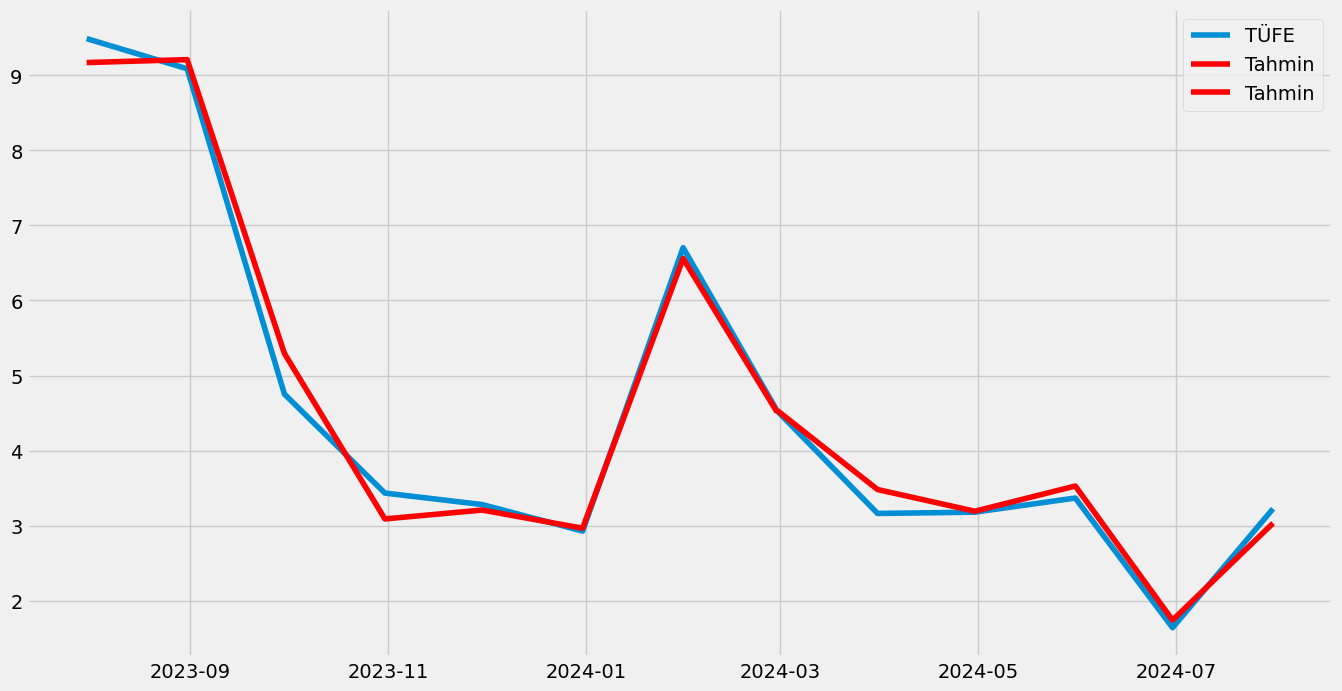

In [184]:
plt.figure(figsize=(15,8))
plt.plot(kısatahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(kısatahminler["Ortalama"].iloc[:8],label="Tahmin",color="red")
plt.plot(kısatahminler["Ensemble"].iloc[7:-1],label="Tahmin",color="red")
plt.legend()

## Orta Vadeli Tahminler

In [105]:
kredi.iloc[-1]=3.88

In [108]:
money.iloc[-1]=3.88

In [109]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.215000
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000
2025-02-28,50.000000


In [110]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [111]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2024-04-30,2862.071302
2024-05-31,2679.695793
2024-06-30,2684.339030
2024-07-31,2738.228154


In [112]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [113]:
faiztahmin.columns=["Faiz"]


In [114]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [115]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [116]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [117]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-07-31,9.209575
2024-08-31,9.167524
2024-09-30,9.302068
2024-10-31,9.303669
2024-11-30,9.296117
2024-12-31,9.321257
2025-01-31,9.321562
2025-02-28,9.320126
2025-03-31,9.324906
2025-04-30,9.324964


In [118]:
from prophet import Prophet

In [119]:
import optuna


In [120]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [121]:
"""study.best_params"""

'study.best_params'

In [122]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:11:15 - cmdstanpy - INFO - Chain [1] start processing
15:11:16 - cmdstanpy - INFO - Chain [1] done processing


In [123]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-09-30    0.845830
2024-10-31    1.650415
2024-11-30    1.623619
2024-12-31    1.597679
2025-01-31    1.598334
2025-02-28    1.497067
2025-03-31    1.474986
2025-04-30    1.502819
2025-05-31    1.480568
2025-06-30    1.458967
2025-07-31    1.437988
2025-08-31    1.440842
2025-09-30    1.397467
2025-10-31    1.378207
2025-11-30    1.359471
2025-12-31    1.341237
2026-01-31    0.954646
Freq: ME, Name: yhat, dtype: float64

In [124]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-09-30    0.845830
2024-10-31    1.650415
2024-11-30    1.623619
2024-12-31    1.597679
2025-01-31    1.598334
2025-02-28    1.497067
2025-03-31    1.474986
2025-04-30    1.502819
2025-05-31    1.480568
2025-06-30    1.458967
2025-07-31    1.437988
2025-08-31    1.440842
2025-09-30    1.397467
2025-10-31    1.378207
2025-11-30    1.359471
2025-12-31    1.341237
2026-01-31    0.954646
Freq: ME, Name: yhat, dtype: float64

In [125]:
usd_aylık=usd.resample('M').mean().dropna()

In [126]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.602300
2024-09-30,33.886518
2024-10-31,34.445787
2024-11-30,35.005055
2024-12-31,35.564323


In [127]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [128]:
"""study.best_params"""

'study.best_params'

In [129]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=10.333547662504625,changepoint_range=0.8962159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing


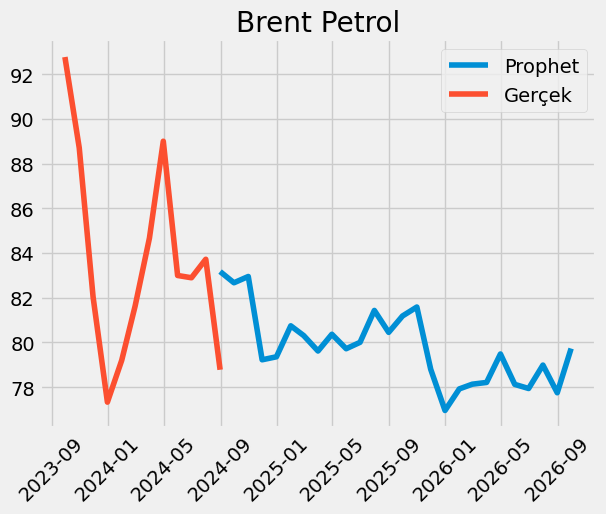

In [130]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [131]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-05-31    81.287425
2024-06-30    82.044556
2024-07-31    83.863629
2024-08-31    83.167520
2024-09-30    82.665321
2024-10-31    82.946379
2024-11-30    79.219295
2024-12-31    79.353264
2025-01-31    80.739397
2025-02-28    80.302649
2025-03-31    79.611109
2025-04-30    80.361781
2025-05-31    79.714221
2025-06-30    80.000262
2025-07-31    81.428299
2025-08-31    80.446624
2025-09-30    81.180030
2025-10-31    81.580362
2025-11-30    78.796053
2025-12-31    76.950375
2026-01-31    77.916320
2026-02-28    78.127002
2026-03-31    78.205745
2026-04-30    79.478985
2026-05-31    78.118325
2026-06-30    77.934426
2026-07-31    78.982630
2026-08-31    77.744053
2026-09-30    79.723688
Name: yhat, dtype: float64

In [132]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing


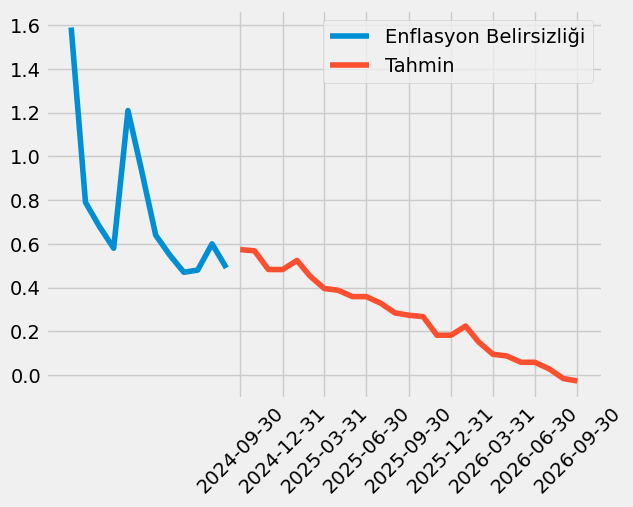

In [133]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=5,changepoint_range=0.85,seasonality_prior_scale=0.0053403857042852,n_changepoints=4,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [134]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-08-31,0.490000
2024-09-30,0.573990
2024-10-31,0.568020
2024-11-30,0.482672
2024-12-31,0.482448
2025-01-31,0.524270
2025-02-28,0.452940
2025-03-31,0.395836
2025-04-30,0.387650


In [135]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [136]:
#study.best_params

In [137]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-06-30    0.931425
2024-07-31    2.217176
2024-08-31   -0.830049
2024-09-30   -0.603839
2024-10-31    0.339995
2024-11-30   -4.493366
2024-12-31    0.169111
2025-01-31    1.746789
2025-02-28   -0.540936
2025-03-31   -0.861167
2025-04-30    0.942924
2025-05-31   -0.805806
2025-06-30    0.358833
2025-07-31    1.785041
2025-08-31   -1.205570
2025-09-30    0.911668
2025-10-31    0.493142
2025-11-30   -3.412965
2025-12-31   -2.342348
2026-01-31    1.255283
2026-02-28    0.270395
2026-03-31    0.100788
2026-04-30    1.628065
2026-05-31   -1.711974
2026-06-30   -0.235411
2026-07-31    1.344982
2026-08-31   -1.568164
2026-09-30    2.546349
Name: yhat, dtype: float64

In [138]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-8]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-06-30",periods=len(motorintahmin),freq="1M"))
motorintahmin=(motorintahmin-1)*100
motorintahmin

,Motorin
2024-06-30,1.786984
2024-07-31,3.390367
2024-08-31,1.303832
2024-09-30,0.236883
2024-10-31,1.996022
2024-11-30,-2.942702
2024-12-31,1.769492
2025-01-31,3.373042
2025-02-28,0.948033
2025-03-31,0.601116


In [139]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [140]:
money.iloc[-1]=3.19

In [141]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:11:19 - cmdstanpy - INFO - Chain [1] start processing
15:11:19 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
paraarzitahmin=(predictions["yhat"]).tail(26)
paraarzitahmin

ds
2024-08-31    2.250431
2024-09-30    3.494437
2024-10-31    3.356460
2024-11-30    3.038134
2024-12-31    3.124568
2025-01-31    1.689379
2025-02-28    2.018433
2025-03-31    3.718409
2025-04-30    3.263301
2025-05-31    2.861863
2025-06-30    3.261705
2025-07-31    2.428822
2025-08-31    2.599079
2025-09-30    2.667738
2025-10-31    2.396226
2025-11-30    2.369934
2025-12-31    3.081681
2026-01-31    1.218678
2026-02-28    1.811715
2026-03-31    3.217960
2026-04-30    2.180064
2026-05-31    2.411350
2026-06-30    3.060415
2026-07-31    1.776975
2026-08-31    2.941995
2026-09-30    1.822186
Name: yhat, dtype: float64

In [143]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-03-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-03-31,1.023967
2024-04-30,1.044264
2024-05-31,1.063682
2024-06-30,1.096729
2024-07-31,1.123738
2024-08-31,1.159585
2024-09-30,1.185681
2024-10-31,1.227114
2024-11-30,1.268302
2024-12-31,1.306834


In [144]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [145]:
#study.best_params

In [146]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [147]:
"""study.best_params"""

'study.best_params'

In [148]:
kredi.iloc[-1]=3.15

In [149]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing


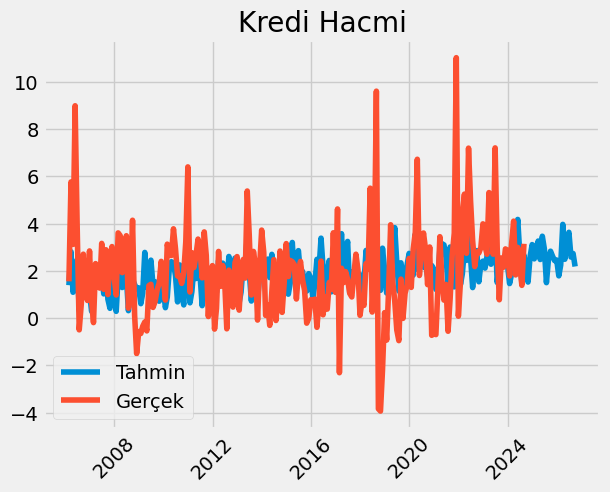

In [150]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [151]:
kreditahmin=(predictions["yhat"]).tail(26)
kreditahmin

ds
2024-08-31    2.668945
2024-09-30    2.134502
2024-10-31    1.529636
2024-11-30    2.597991
2024-12-31    3.116269
2025-01-31    2.511269
2025-02-28    2.954447
2025-03-31    3.266643
2025-04-30    2.483443
2025-05-31    3.470413
2025-06-30    2.940193
2025-07-31    1.504773
2025-08-31    2.515422
2025-09-30    2.836440
2025-10-31    2.615678
2025-11-30    2.437405
2025-12-31    2.461492
2026-01-31    1.791590
2026-02-28    2.247024
2026-03-31    3.971637
2026-04-30    2.494300
2026-05-31    3.308708
2026-06-30    3.635675
2026-07-31    2.587830
2026-08-31    2.737989
2026-09-30    2.188319
Name: yhat, dtype: float64

In [152]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-05-31,2.996833
2024-06-30,2.281882
2024-07-31,1.391026
2024-08-31,3.150000
2024-09-30,2.668945
2024-10-31,2.134502
2024-11-30,1.529636
2024-12-31,2.597991
2025-01-31,3.116269
2025-02-28,2.511269


In [153]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [154]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:21 - cmdstanpy - INFO - Chain [1] done processing


In [155]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-05-31,3.570039
2024-06-30,3.196057
2024-07-31,3.097549
2024-08-31,4.961059
2024-09-30,3.471221
2024-10-31,3.676849
2024-11-30,3.298341
2024-12-31,2.586476
2025-01-31,1.649208
2025-02-28,2.148129


In [156]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [157]:
#study.best_params

In [158]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [159]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1["M3"].shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.rolling(3).mean()
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].shift(1).rolling(2).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"].rolling(2).mean()
tahmindf["İşsizlik"]=issizliktahmin





tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik']



tahmindf=tahmindf.loc["2024-08-31":]
tahmindf["Motorin"].iloc[0]=data["Motorin"].iloc[-1]
tahmindf["ParaArzi"].iloc[0]=data["ParaArzi"].iloc[-1]
tahmindf["M3"].iloc[0]=data["M3"].iloc[-1]
tahmindf["Kredi"].iloc[0]=data["Kredi"].iloc[-1]
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik
2024-08-31,1.386820,3.714429,0.0,0.490000,3.150000,3.751555,1.836454,9.167524
2024-09-30,1.378823,0.770358,0.0,0.573990,2.634385,4.961059,2.270513,9.302068
2024-10-31,1.545368,1.116453,0.0,0.568020,2.978289,3.471221,2.909472,9.303669
2024-11-30,1.376132,-0.473340,0.0,0.482672,3.033776,3.676849,2.401723,9.296117
2024-12-31,1.623619,-0.586605,0.0,0.482448,3.296343,3.298341,1.832069,9.321257
2025-01-31,1.606409,2.571267,30.0,0.524270,3.173054,2.586476,2.063813,9.321562
2025-02-28,1.563827,2.160538,0.0,0.452940,2.617360,1.649208,2.857130,9.320126
2025-03-31,1.522828,0.774575,0.0,0.395836,2.277460,2.148129,2.813769,9.324906
2025-04-30,1.491652,1.530515,0.0,0.387650,2.475407,3.588470,2.732858,9.324964
2025-05-31,1.486150,1.561373,0.0,0.358675,3.000048,3.155836,3.110545,9.324691


In [160]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,Zam,TÜFE
0,0.068189,-0.370015,-0.794250,-0.937856,-0.647882,-0.281596,0.275997,-0.665696,-1.013161,0.359487,-0.702132,-0.288578,-0.526904,-0.681547,-0.692300,-0.288811,-0.347333
1,-1.073148,-0.992627,-1.193718,-0.759082,-0.338442,-0.949728,0.846270,1.077722,-0.882028,-0.292136,-0.518092,-0.506659,-0.293943,-0.599818,-1.078167,-0.288811,-0.249930
2,-1.227400,-0.857350,-1.336742,-0.682464,-0.241111,-1.075969,-0.694849,-0.026438,-0.882028,-0.510114,-0.285510,-0.725841,0.138773,-0.696407,-1.294033,-0.288811,-0.671642
3,-1.145360,-0.150904,-0.949861,-0.529229,-0.662510,-0.906026,0.033332,-0.062831,-0.882028,-0.729193,0.146501,-0.930106,-0.150501,-1.001033,-0.946662,-0.288811,-0.709132
4,-0.711934,-0.101498,-0.692631,-0.631386,-0.699973,-0.073070,-0.570198,-0.054830,-0.750895,-0.933361,-0.142301,-0.735836,-0.712668,-1.119912,-0.634532,0.265107,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.064147,-0.397438,0.088495,0.058173,0.565396,1.012983,0.455042,0.583963,-1.537695,0.500144,0.827086,0.355196,0.798229,1.250230,-0.195050,-0.288811,0.564763
122,-0.201458,-0.464112,0.324147,-0.146141,0.572978,0.624309,-1.208591,-0.310643,-1.668828,0.351333,0.804884,0.458860,0.815957,1.094202,-0.125210,-0.288811,0.648374
123,-0.504581,-0.557291,0.423089,-0.120602,0.656528,0.291429,1.806640,0.365494,-1.209861,0.454948,0.822583,-0.095174,0.909005,0.707846,0.001229,-0.288811,-0.118586
124,-0.496074,0.418207,0.557907,0.185869,-0.109864,0.426098,-1.819053,-1.714837,-1.734395,-0.098849,0.915479,-0.291053,-0.045372,0.893594,0.086777,-0.288811,0.585098


In [161]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['M3','ParaArzi','Enflasyon Belirsizliği','Kredi','İşsizlik']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = ["USD/TL","Motorin","Zam"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

'import optuna\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN\nimport keras\nfrom keras.callbacks import EarlyStopping\nfrom keras import regularizers\nfrom keras.layers import LSTM, Dense, Dropout\nfrom keras.regularizers import l2,l1\nfeatures=[\'M3\',\'ParaArzi\',\'Enflasyon Belirsizliği\',\'Kredi\',\'İşsizlik\']\ndef weighted_mse(y_true, y_pred):\n    n = len(y_true)\n    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar\n    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)\n    mse = np.sum(weights * (y_true - y_pred) ** 2) / n\n    return mse\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    selected_features = ["USD/TL","Motorin","Zam"]\n    for feature in features:\n        if trial.suggest_categorical(feature, (True, False)):\n            selected_features.append(feature)\n\n    if len(selected_features) == 0:\n        return float(\'i

In [162]:
trials=pd.read_excel("futuretrial2.xlsx")
del trials["Unnamed: 0"]
predictions=pd.DataFrame()
for i in range(20):
    features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

    data1=data[features]
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler2 = StandardScaler()
    scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    features = [col for col in cleaned_column_names if col not in columns_to_drop]
    features.append("USD/TL")
    features.append("Motorin")
    features.append("Zam")



    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))

    features.append("TÜFE")
    data1=pd.concat([data,tahmindf],axis=0)
    data1=data1[features]
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler = StandardScaler()
    scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))

    X=scaled_data.iloc[:,:-1]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_test=scaled_data.iloc[-len(tahmindf):,:-1]


    pred=scaler.inverse_transform(model.predict(np.array(X_test)))
    pred=pd.DataFrame(pred)
    pred.columns=["TÜFE"]
    pred=pred.set_index(pd.date_range(start="2024-08-30",periods=len(tahmindf),freq="1M"))
    pred.iloc[0]=2.54
    predictions=pd.concat([predictions,pred["TÜFE"]],axis=1)
    

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - loss: 9.4124 - mean_squared_error: 2.0553 - val_loss: 6.4330 - val_mean_squared_error: 4.8337
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.5434 - mean_squared_error: 3.0957 - val_loss: 1.9841 - val_mean_squared_error: 0.2755
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3769 - mean_squared_error: 0.5899 - val_loss: 2.4746 - val_mean_squared_error: 0.7448
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 9.1991 - mean_squared_error: 1.8024 - val_loss: 5.8946 - val_mean_squared_error: 4.3158
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3166 - mean_squared_error: 2.9095 - val_loss: 1.8158 - val_mean_squared_error: 0.1888
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2216 - mean_squared_error: 0.4780 - val_loss: 2.3507 - val_mean_squared_error: 0.5369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s

In [163]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-08-31", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [164]:
tüfetahmin_dict={}
for i in range(len(predictions.columns)):
    # Dinamik olarak bir sözlük içinde tahminleri saklıyoruz.
    tüfetahmin_dict[f"tüfetahmin_{i}"] = create_tüfe(predictions.iloc[:, i])
    # Kolon adını güncelleme
    tüfetahmin_dict[f"tüfetahmin_{i}"].columns = [f"NN_{i}"]




In [165]:
tüfetahmin=pd.concat(tüfetahmin_dict.values(), axis=1)


In [166]:
std=tüfetahmin.std(axis=1)

In [167]:
predictions.columns=tüfetahmin.columns

In [168]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=["Ortalama"]


dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.max(axis=1)+std],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["Max"]

dfas2["Max"].loc["2024-08-31":"2024-12-31"]-=std.loc["2024-08-31":"2024-12-31"]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.min(axis=1)-std],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["Min"]
dfas0=pd.DataFrame()
for i in range(tüfetahmin.shape[1]):
    dfas00=pd.DataFrame()
    dfas00=pd.concat([df["CPI"],tüfetahmin.iloc[:,i]],axis=0)
    dfas00=pd.DataFrame(dfas00)
    dfas00.columns=[f"NN_{i}"]
    dfas0=pd.concat([dfas0,dfas00],axis=1)



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas0],axis=1)
dfas=dfas.dropna(axis=0)
dfas=dfas[["NN_3","NN_6","NN_11","NN_10","NN_12"]]
dfas["Ortalama"]=dfas.mean(axis=1)
dfas=pd.concat([dfas,dfas2,dfas3],axis=1)
dfas=dfas.pct_change(periods=12)*100
df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)







In [169]:
predictions=predictions[dfas.columns[:-3]]
predictions["Ortalama"]=predictions.mean(axis=1)

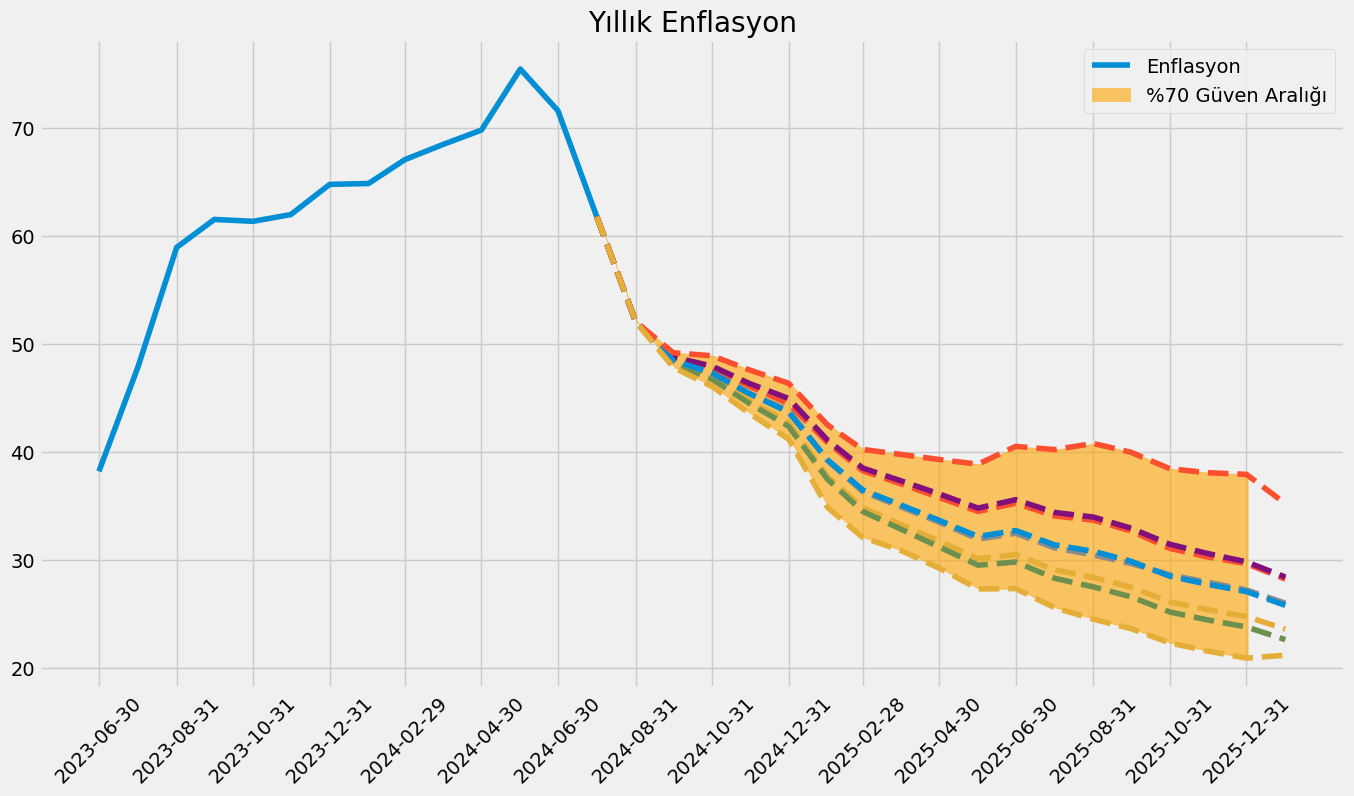

In [170]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(dfas["Ortalama"].loc["2023-06-30":"2024-08-30"],label="Enflasyon")
plt.plot(dfas.loc["2024-07-30":],'--')
plt.fill_between(dfas.loc["2024-07-30":].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":].shift(1), dfas["Min"].loc["2024-07-30":].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
plt.legend(loc=0)
plt.xticks(dfas.loc["2023-06-30":].index[::2],rotation=45)
plt.title("Yıllık Enflasyon")
plt.show()

In [171]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [172]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-08-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-08-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-08-31,43.31


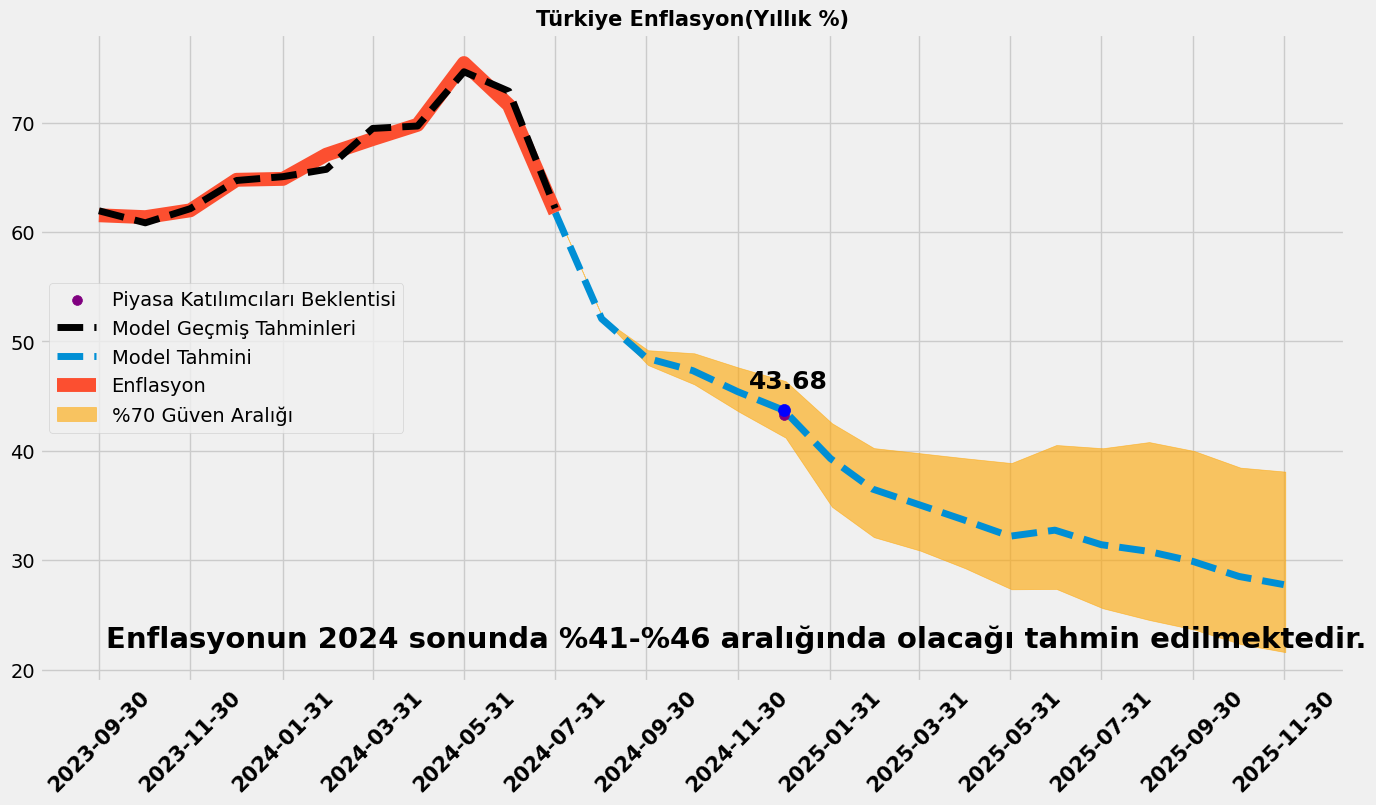

In [173]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87,62.17]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",periods=len(geçmiş),freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-07-30":"2025-12-30"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-08-30"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-07-30":"2026-01-30"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":"2026-01-30"].shift(1), dfas["Min"].loc["2024-07-30":"2026-01-30"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-11')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')
plt.xticks(dfas.loc["2023-09-30":"2025-12-30"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()

In [184]:
std

2024-08-31      0.000000
2024-09-30      5.307314
2024-10-31     11.673164
2024-11-30     16.745826
2024-12-31     22.011757
2025-01-31     27.880111
2025-02-28     32.629044
2025-03-31     37.614512
2025-04-30     43.372585
2025-05-31     50.151589
2025-06-30     57.151839
2025-07-31     65.120387
2025-08-31     73.439595
2025-09-30     80.424809
2025-10-31     87.877723
2025-11-30     95.477050
2025-12-31    103.261868
2026-01-31    102.034233
Freq: ME, dtype: float64

In [174]:
cari

,NN0,NN1,NN2,NN3,NN4,Ortalama,Medyan,TÜFE
2024-02-29,4.545530,4.666243,4.549954,4.616568,4.534013,4.594574,4.583261,4.529188
2024-03-31,3.289372,3.232483,3.312304,3.189750,3.265798,3.255978,3.260928,3.162671
2024-04-30,3.074509,3.024165,3.095102,2.980672,3.057980,3.043612,3.049337,3.179759
2024-05-31,3.201561,3.305071,3.217776,3.307345,3.183784,3.257938,3.261424,3.368063
2024-06-30,1.668398,1.682426,1.666761,1.600345,1.670015,1.654482,1.667579,1.640774
2024-07-31,3.316795,3.326655,3.333118,3.332542,3.301596,3.327277,3.329599,3.225556
2024-08-31,2.815898,2.645439,2.815941,2.583710,2.819737,2.715247,2.730669,0.000000


In [175]:
predictions.columns=["NN1","NN2","NN3","NN4","NN5","Ortalama"]

In [176]:
cari.iloc[-1:,:-4]

,NN0,NN1,NN2,NN3
2024-08-31,2.815898,2.645439,2.815941,2.58371


In [177]:
modelaylık=cari.iloc[-1:,:-4]
modelaylık["Ortalama"]=cari["Ortalama"].iloc[-1]
modelaylık["Ensemble"]=kısatahminler["Ensemble"].iloc[-1]
modelaylık

,NN0,NN1,NN2,NN3,Ortalama,Ensemble
2024-08-31,2.815898,2.645439,2.815941,2.58371,2.715247,2.18349


In [178]:

aylık=pd.concat([data["TÜFE"][:-1],predictions["Ortalama"]],axis=0)
aylık

2014-03-31    1.125608
2014-04-30    1.344970
2014-05-31    0.395224
2014-06-30    0.310791
2014-07-31    0.454414
                ...   
2025-09-30    1.548400
2025-10-31    1.537792
2025-11-30    1.336894
2025-12-31    1.171923
2026-01-31    2.393680
Length: 143, dtype: float64

In [179]:
aylık.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv")

In [180]:
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [181]:
yıllıktahmin1=dfas


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-07')])

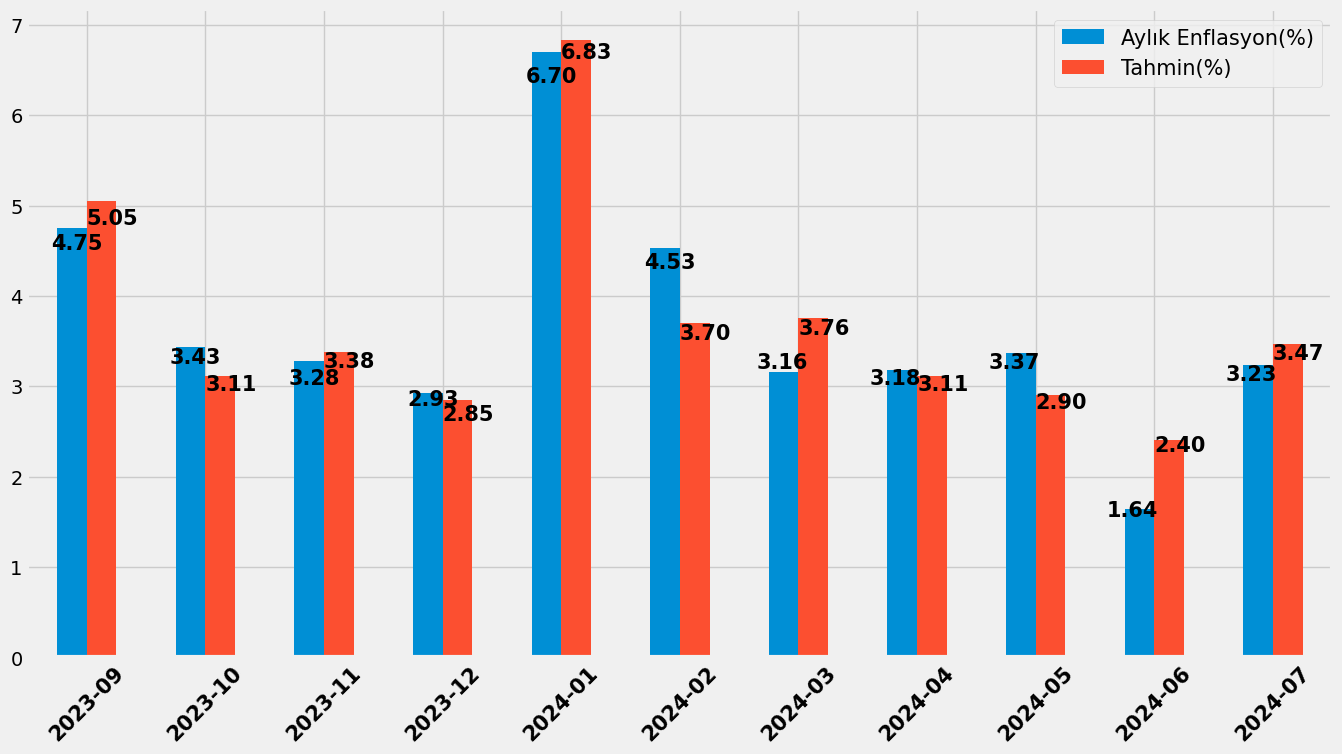

In [182]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64,3.23],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40,3.47]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=11,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.92),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.92),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.97),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.23",xy=(9.6,gecmis.iloc[10,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.47",xy=(10,gecmis.iloc[10,1]*0.95),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=45,fontweight="bold",fontsize=15,color="black")